In [1]:
import pickle
from typing import Iterable, Literal, Optional

import cheetah
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import torch
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch import nn
from tqdm import trange

In [2]:
torch.manual_seed(42)

In [3]:
plt.style.use(["science", "ieee", "no-latex"])

In [4]:
def batched(iterable: Iterable, size: int = 1) -> Iterable:
    length = len(iterable)
    for ndx in range(0, length, size):
        yield iterable[ndx : min(ndx + size, length)]

In [5]:
# Load data from two different runs

with open("rl_firstsub_real_32.pkl", "rb") as f:
    rl_data = pickle.load(f)

with open("bo_firstsub_real_32.pkl", "rb") as f:
    bo_data = pickle.load(f)

with open("rl_sim_33.pkl", "rb") as f:
    rl_data_sim = pickle.load(f)

In [6]:
real_combined = {"observations": rl_data["observations"] + bo_data["observations"]}

In [7]:
# Load ARES lattice and wrap it in normalisation nn.Module


class NormalizedARESEAMisalignments(nn.Module):
    """
    Wrapper around the ARES experimental area lattice that normalises the
    quadrupole misalignments.
    """

    MAX_MISALIGNMENT = 0.5e-3  # 0.5 mm

    def __init__(
        self,
        incoming: Literal[
            "rl_sim_data", "centered_rl_sim_data", "centered_astra", "uncentered_astra"
        ] = "centered_astra",
    ):
        super().__init__()

        self.ares_ea = cheetah.Segment.from_lattice_json(
            "ARESlatticeStage3v1_9.json"
        ).subcell("AREASOLA1", "AREABSCR1")

        # Load a beam that's close to a design beam and move it to zero mu. Zero mu is
        # assumed because we need to define origin somehow and at ARES ballistic
        # trajectory is preferred.
        if incoming == "rl_sim_data":
            incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_parameters(
                energy=torch.tensor(incoming_parameters[0], dtype=torch.float32),
                mu_x=torch.tensor(incoming_parameters[1], dtype=torch.float32),
                mu_xp=torch.tensor(incoming_parameters[2], dtype=torch.float32),
                mu_y=torch.tensor(incoming_parameters[3], dtype=torch.float32),
                mu_yp=torch.tensor(incoming_parameters[4], dtype=torch.float32),
                sigma_x=torch.tensor(incoming_parameters[5], dtype=torch.float32),
                sigma_xp=torch.tensor(incoming_parameters[6], dtype=torch.float32),
                sigma_y=torch.tensor(incoming_parameters[7], dtype=torch.float32),
                sigma_yp=torch.tensor(incoming_parameters[8], dtype=torch.float32),
                sigma_s=torch.tensor(incoming_parameters[9], dtype=torch.float32),
                sigma_p=torch.tensor(incoming_parameters[10], dtype=torch.float32),
            )
        elif incoming == "centered_rl_sim_data":
            incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_parameters(
                energy=torch.tensor(incoming_parameters[0], dtype=torch.float32),
                mu_x=torch.tensor(0.0),
                mu_xp=torch.tensor(0.0),
                mu_y=torch.tensor(0.0),
                mu_yp=torch.tensor(0.0),
                sigma_x=torch.tensor(incoming_parameters[5], dtype=torch.float32),
                sigma_xp=torch.tensor(incoming_parameters[6], dtype=torch.float32),
                sigma_y=torch.tensor(incoming_parameters[7], dtype=torch.float32),
                sigma_yp=torch.tensor(incoming_parameters[8], dtype=torch.float32),
                sigma_s=torch.tensor(incoming_parameters[9], dtype=torch.float32),
                sigma_p=torch.tensor(incoming_parameters[10], dtype=torch.float32),
            )
        elif incoming == "centered_astra":
            self.incoming_beam = cheetah.ParameterBeam.from_astra(
                "ACHIP_EA1_2021.1351.001"
            ).transformed_to(
                mu_x=torch.tensor(0.0),
                mu_y=torch.tensor(0.0),
                mu_xp=torch.tensor(0.0),
                mu_yp=torch.tensor(0.0),
            )
        elif incoming == "uncentered_astra":
            rl_sim_incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_astra(
                "ACHIP_EA1_2021.1351.001"
            ).transformed_to(
                mu_x=torch.tensor(rl_sim_incoming_parameters[1], dtype=torch.float32),
                mu_xp=torch.tensor(rl_sim_incoming_parameters[2], dtype=torch.float32),
                mu_y=torch.tensor(rl_sim_incoming_parameters[3], dtype=torch.float32),
                mu_yp=torch.tensor(rl_sim_incoming_parameters[4], dtype=torch.float32),
            )
        else:
            raise ValueError(f"Unknown incoming beam {incoming}")

        self.normalized_misalignments_q1 = nn.Parameter(torch.randn(2) * 2 - 1)
        self.normalized_misalignments_q2 = nn.Parameter(torch.randn(2) * 2 - 1)
        self.normalized_misalignments_q3 = nn.Parameter(torch.randn(2) * 2 - 1)

    def forward(self, magnet_settings):
        # Set the magnet settings as they were in the ground truth sample
        self.ares_ea.AREAMQZM1.k1 = magnet_settings[0]
        self.ares_ea.AREAMQZM2.k1 = magnet_settings[1]
        self.ares_ea.AREAMCVM1.angle = magnet_settings[2]
        self.ares_ea.AREAMQZM3.k1 = magnet_settings[3]
        self.ares_ea.AREAMCHM1.angle = magnet_settings[4]

        # Set the misalignments based on the normalised misalignments
        self.ares_ea.AREAMQZM1.misalignment = (
            self.normalized_misalignments_q1 * self.MAX_MISALIGNMENT
        )
        self.ares_ea.AREAMQZM2.misalignment = (
            self.normalized_misalignments_q2 * self.MAX_MISALIGNMENT
        )
        self.ares_ea.AREAMQZM3.misalignment = (
            self.normalized_misalignments_q3 * self.MAX_MISALIGNMENT
        )

        return self.ares_ea.track(self.incoming_beam)

In [8]:
def train_normalized(model: nn.Module, num_epochs: int, data: dict) -> dict:
    misalignment_q1_history = []
    misalignment_q2_history = []
    misalignment_q3_history = []
    beam_parameter_history = []
    loss_history = []

    magnet_settings = torch.tensor([obs["magnets"] for obs in data["observations"]])
    measured_beams = torch.tensor([obs["beam"] for obs in data["observations"]])

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    for _ in trange(num_epochs):
        epoch_misalignment_q1_history = []
        epoch_misalignment_q2_history = []
        epoch_misalignment_q3_history = []
        epoch_beam_parameter_history = []
        epoch_loss_history = []

        magnet_settings, measured_beams = shuffle(magnet_settings, measured_beams)
        magnet_settings_2, measured_beams_2 = shuffle(magnet_settings, measured_beams)

        optimizer.zero_grad()

        for (
            magnet_setting_batch,
            measured_beam_batch,
            magnet_setting_2_batch,
            measured_beam_2_batch,
        ) in zip(
            batched(magnet_settings, 10),
            batched(measured_beams, 10),
            batched(magnet_settings_2, 10),
            batched(measured_beams_2, 10),
        ):
            batch_loss_history = []

            for magnet_setting, measured_beam, magnet_setting_2, measured_beam_2 in zip(
                magnet_setting_batch,
                measured_beam_batch,
                magnet_setting_2_batch,
                measured_beam_2_batch,
            ):
                outgoing_beam = model(magnet_setting)
                simulated_beam = torch.stack([outgoing_beam.mu_x, outgoing_beam.mu_y])
                outgoing_beam_2 = model(magnet_setting_2)
                simulated_beam_2 = torch.stack(
                    [outgoing_beam_2.mu_x, outgoing_beam_2.mu_y]
                )
                measured_beam_change = (measured_beam_2 - measured_beam)[[0, 2]]
                simulated_beam_change = simulated_beam_2 - simulated_beam
                sample_loss = F.mse_loss(
                    simulated_beam_change / 2e-3, measured_beam_change / 2e-3
                )

                batch_loss_history.append(sample_loss)

                epoch_loss_history.append(sample_loss.detach().numpy())
                epoch_beam_parameter_history.append(simulated_beam.detach().numpy())
                epoch_misalignment_q1_history.append(
                    model.ares_ea.AREAMQZM1.misalignment.detach().numpy()
                )
                epoch_misalignment_q2_history.append(
                    model.ares_ea.AREAMQZM2.misalignment.detach().numpy()
                )
                epoch_misalignment_q3_history.append(
                    model.ares_ea.AREAMQZM3.misalignment.detach().numpy()
                )

            loss = torch.stack(batch_loss_history).mean()
            loss.backward()

            optimizer.step()

        # Log epoch history
        loss_history.append(np.mean(epoch_loss_history))
        beam_parameter_history.append(np.mean(epoch_beam_parameter_history, axis=0))
        misalignment_q1_history.append(np.mean(epoch_misalignment_q1_history, axis=0))
        misalignment_q2_history.append(np.mean(epoch_misalignment_q2_history, axis=0))
        misalignment_q3_history.append(np.mean(epoch_misalignment_q3_history, axis=0))

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "misalignment_q1": misalignment_q1_history,
        "misalignment_q2": misalignment_q2_history,
        "misalignment_q3": misalignment_q3_history,
    }
    return history

In [9]:
def plot_training(
    history: dict,
    ground_truth: Optional[np.ndarray] = None,
    save_path: Optional[str] = None,
) -> None:
    fig, axs = plt.subplots(3, 1, figsize=(3.5, 3.8), sharex=True)

    axs[0].plot(history["loss"])
    axs[0].set_ylabel("Loss")

    axs[1].plot(
        [record[0] * 1e3 for record in history["misalignment_q1"]],
        label=r"$Q_1$",
        linestyle="-",
        c="#FF6F61",
    )
    axs[1].plot(
        [record[0] * 1e3 for record in history["misalignment_q2"]],
        label=r"$Q_2$",
        linestyle="-",
        c="#6B5B95",
    )
    axs[1].plot(
        [record[0] * 1e3 for record in history["misalignment_q3"]],
        label=r"$Q_3$",
        linestyle="-",
        c="#88B04B",
    )
    if ground_truth is not None:
        axs[1].axhline(
            ground_truth[0] * 1e3, color="tab:blue", linestyle="--", c="#FF6F61"
        )
        axs[1].axhline(
            ground_truth[2] * 1e3, color="tab:orange", linestyle="--", c="#6B5B95"
        )
        axs[1].axhline(
            ground_truth[4] * 1e3, color="tab:green", linestyle="--", c="#88B04B"
        )
    axs[1].set_ylabel("x misalignment (mm)")
    axs[1].legend(ncol=3)

    axs[2].plot(
        [record[1] * 1e3 for record in history["misalignment_q1"]],
        label=r"$Q_1$",
        linestyle="-",
        c="#FFD700",
    )
    axs[2].plot(
        [record[1] * 1e3 for record in history["misalignment_q2"]],
        label=r"$Q_2$",
        linestyle="-",
        c="#40E0D0",
    )
    axs[2].plot(
        [record[1] * 1e3 for record in history["misalignment_q3"]],
        label=r"$Q_3$",
        linestyle="-",
        c="#FF7E5F",
    )
    if ground_truth is not None:
        axs[2].axhline(
            ground_truth[1] * 1e3, color="tab:blue", linestyle="--", c="#FFD700"
        )
        axs[2].axhline(
            ground_truth[3] * 1e3, color="tab:orange", linestyle="--", c="#40E0D0"
        )
        axs[2].axhline(
            ground_truth[5] * 1e3, color="tab:green", linestyle="--", c="#FF7E5F"
        )
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("y misalignment (mm)")
    axs[2].legend(ncol=3)

    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path)

    plt.show()

In [10]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history_1 = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)

/var/folders/z8/vzg_1dr50gg1zchydp1styc00000gn/T/ipykernel_36381/3868145760.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  magnet_settings = torch.tensor([obs["magnets"] for obs in data["observations"]])
100%|██████████| 1500/1500 [02:44<00:00,  9.10it/s]


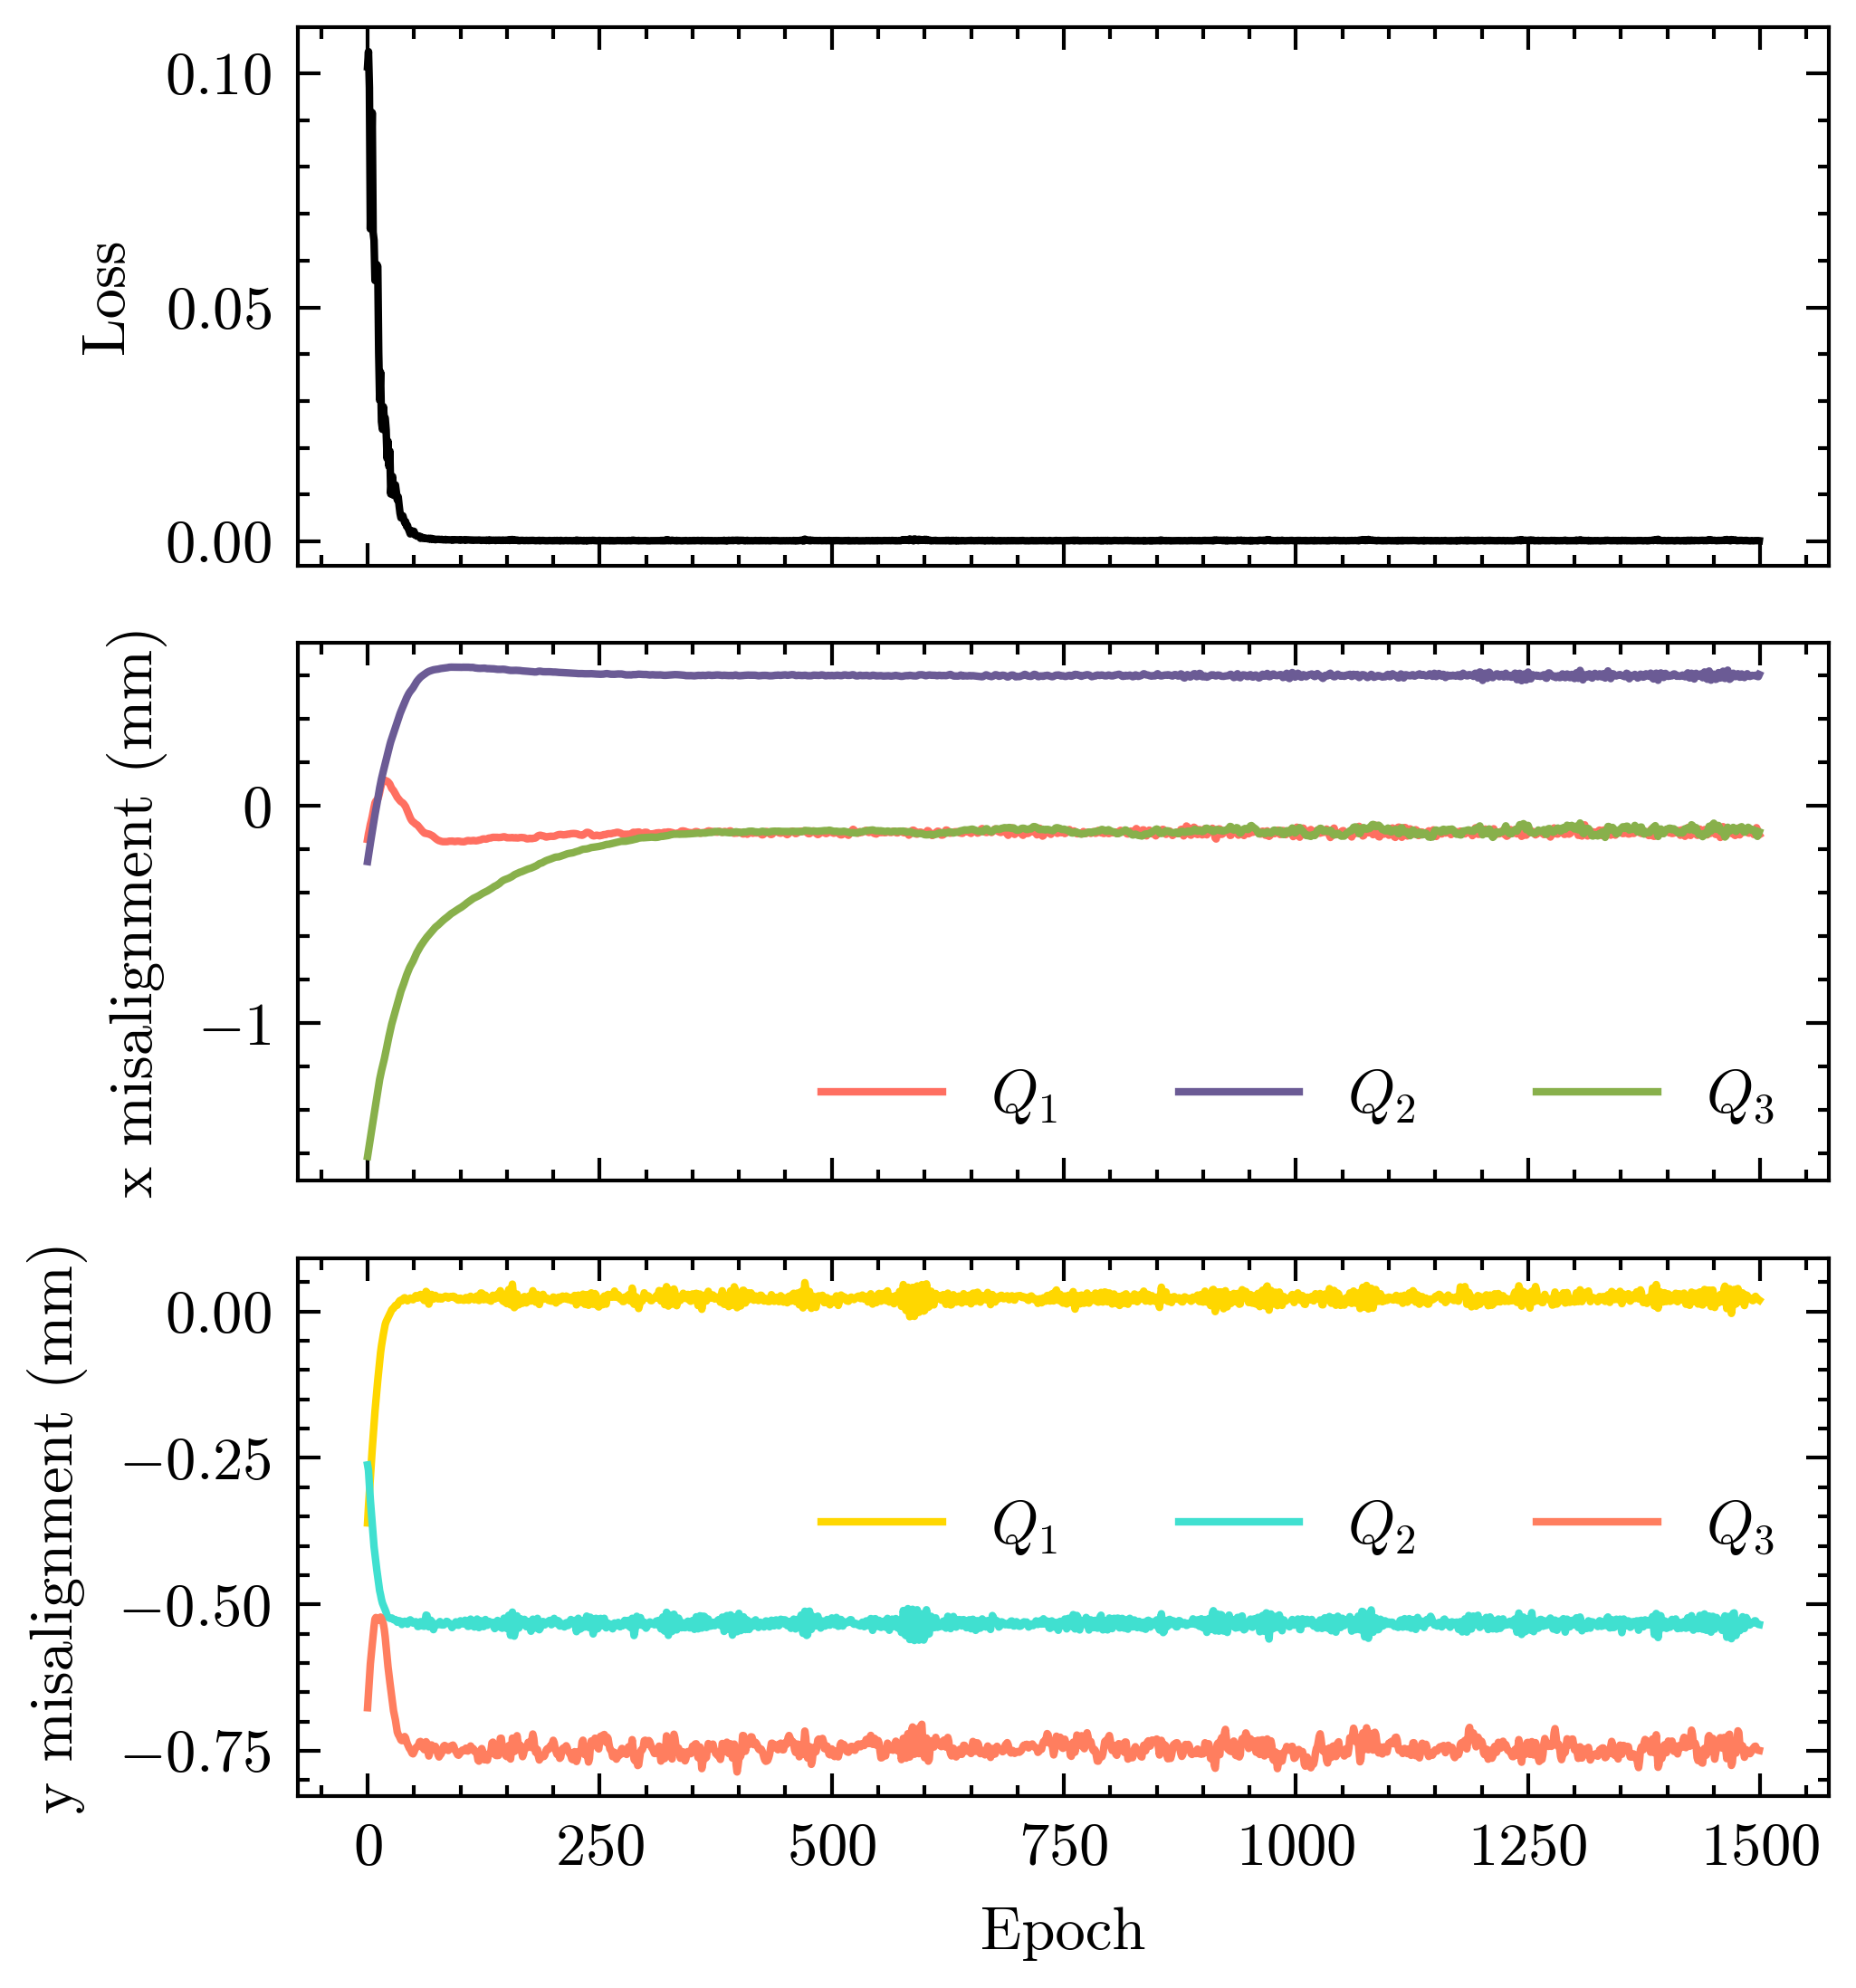

In [11]:
plot_training(history_1)

In [12]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history_2 = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)

100%|██████████| 1500/1500 [02:42<00:00,  9.26it/s]


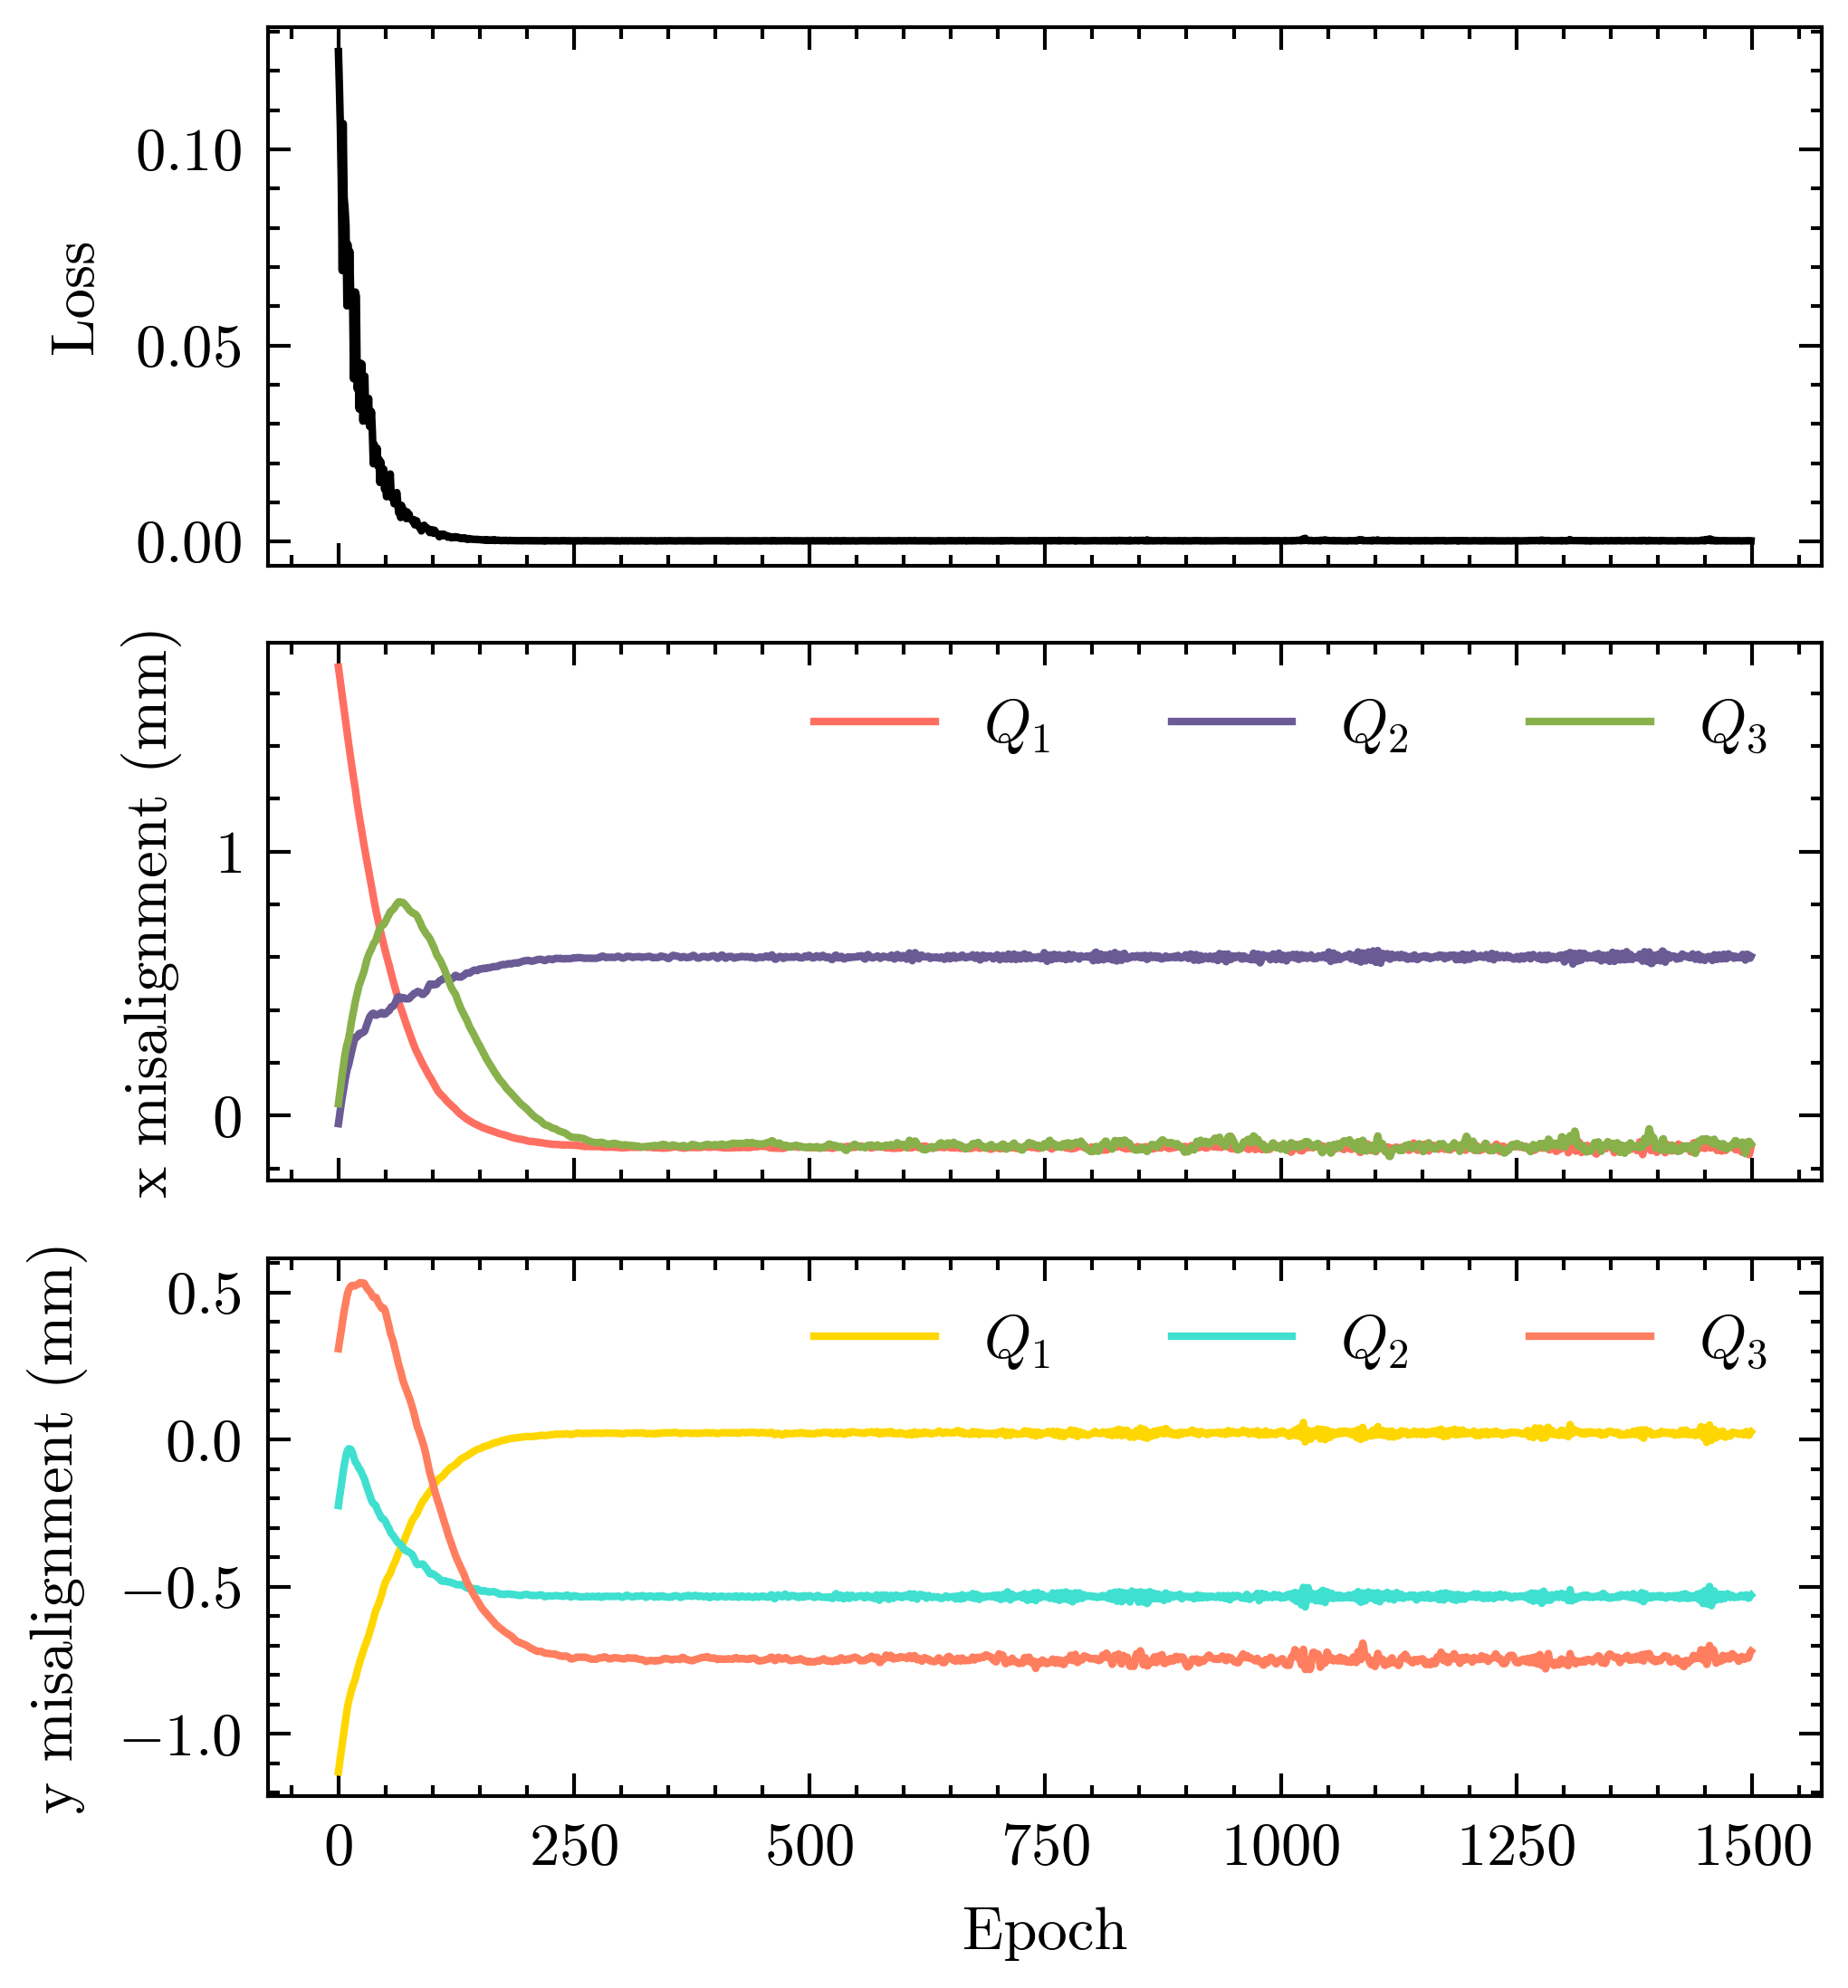

In [13]:
plot_training(history_2, save_path="system_id_real.pdf")

In [14]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="rl_sim_data")
history_3 = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [02:34<00:00,  9.70it/s]


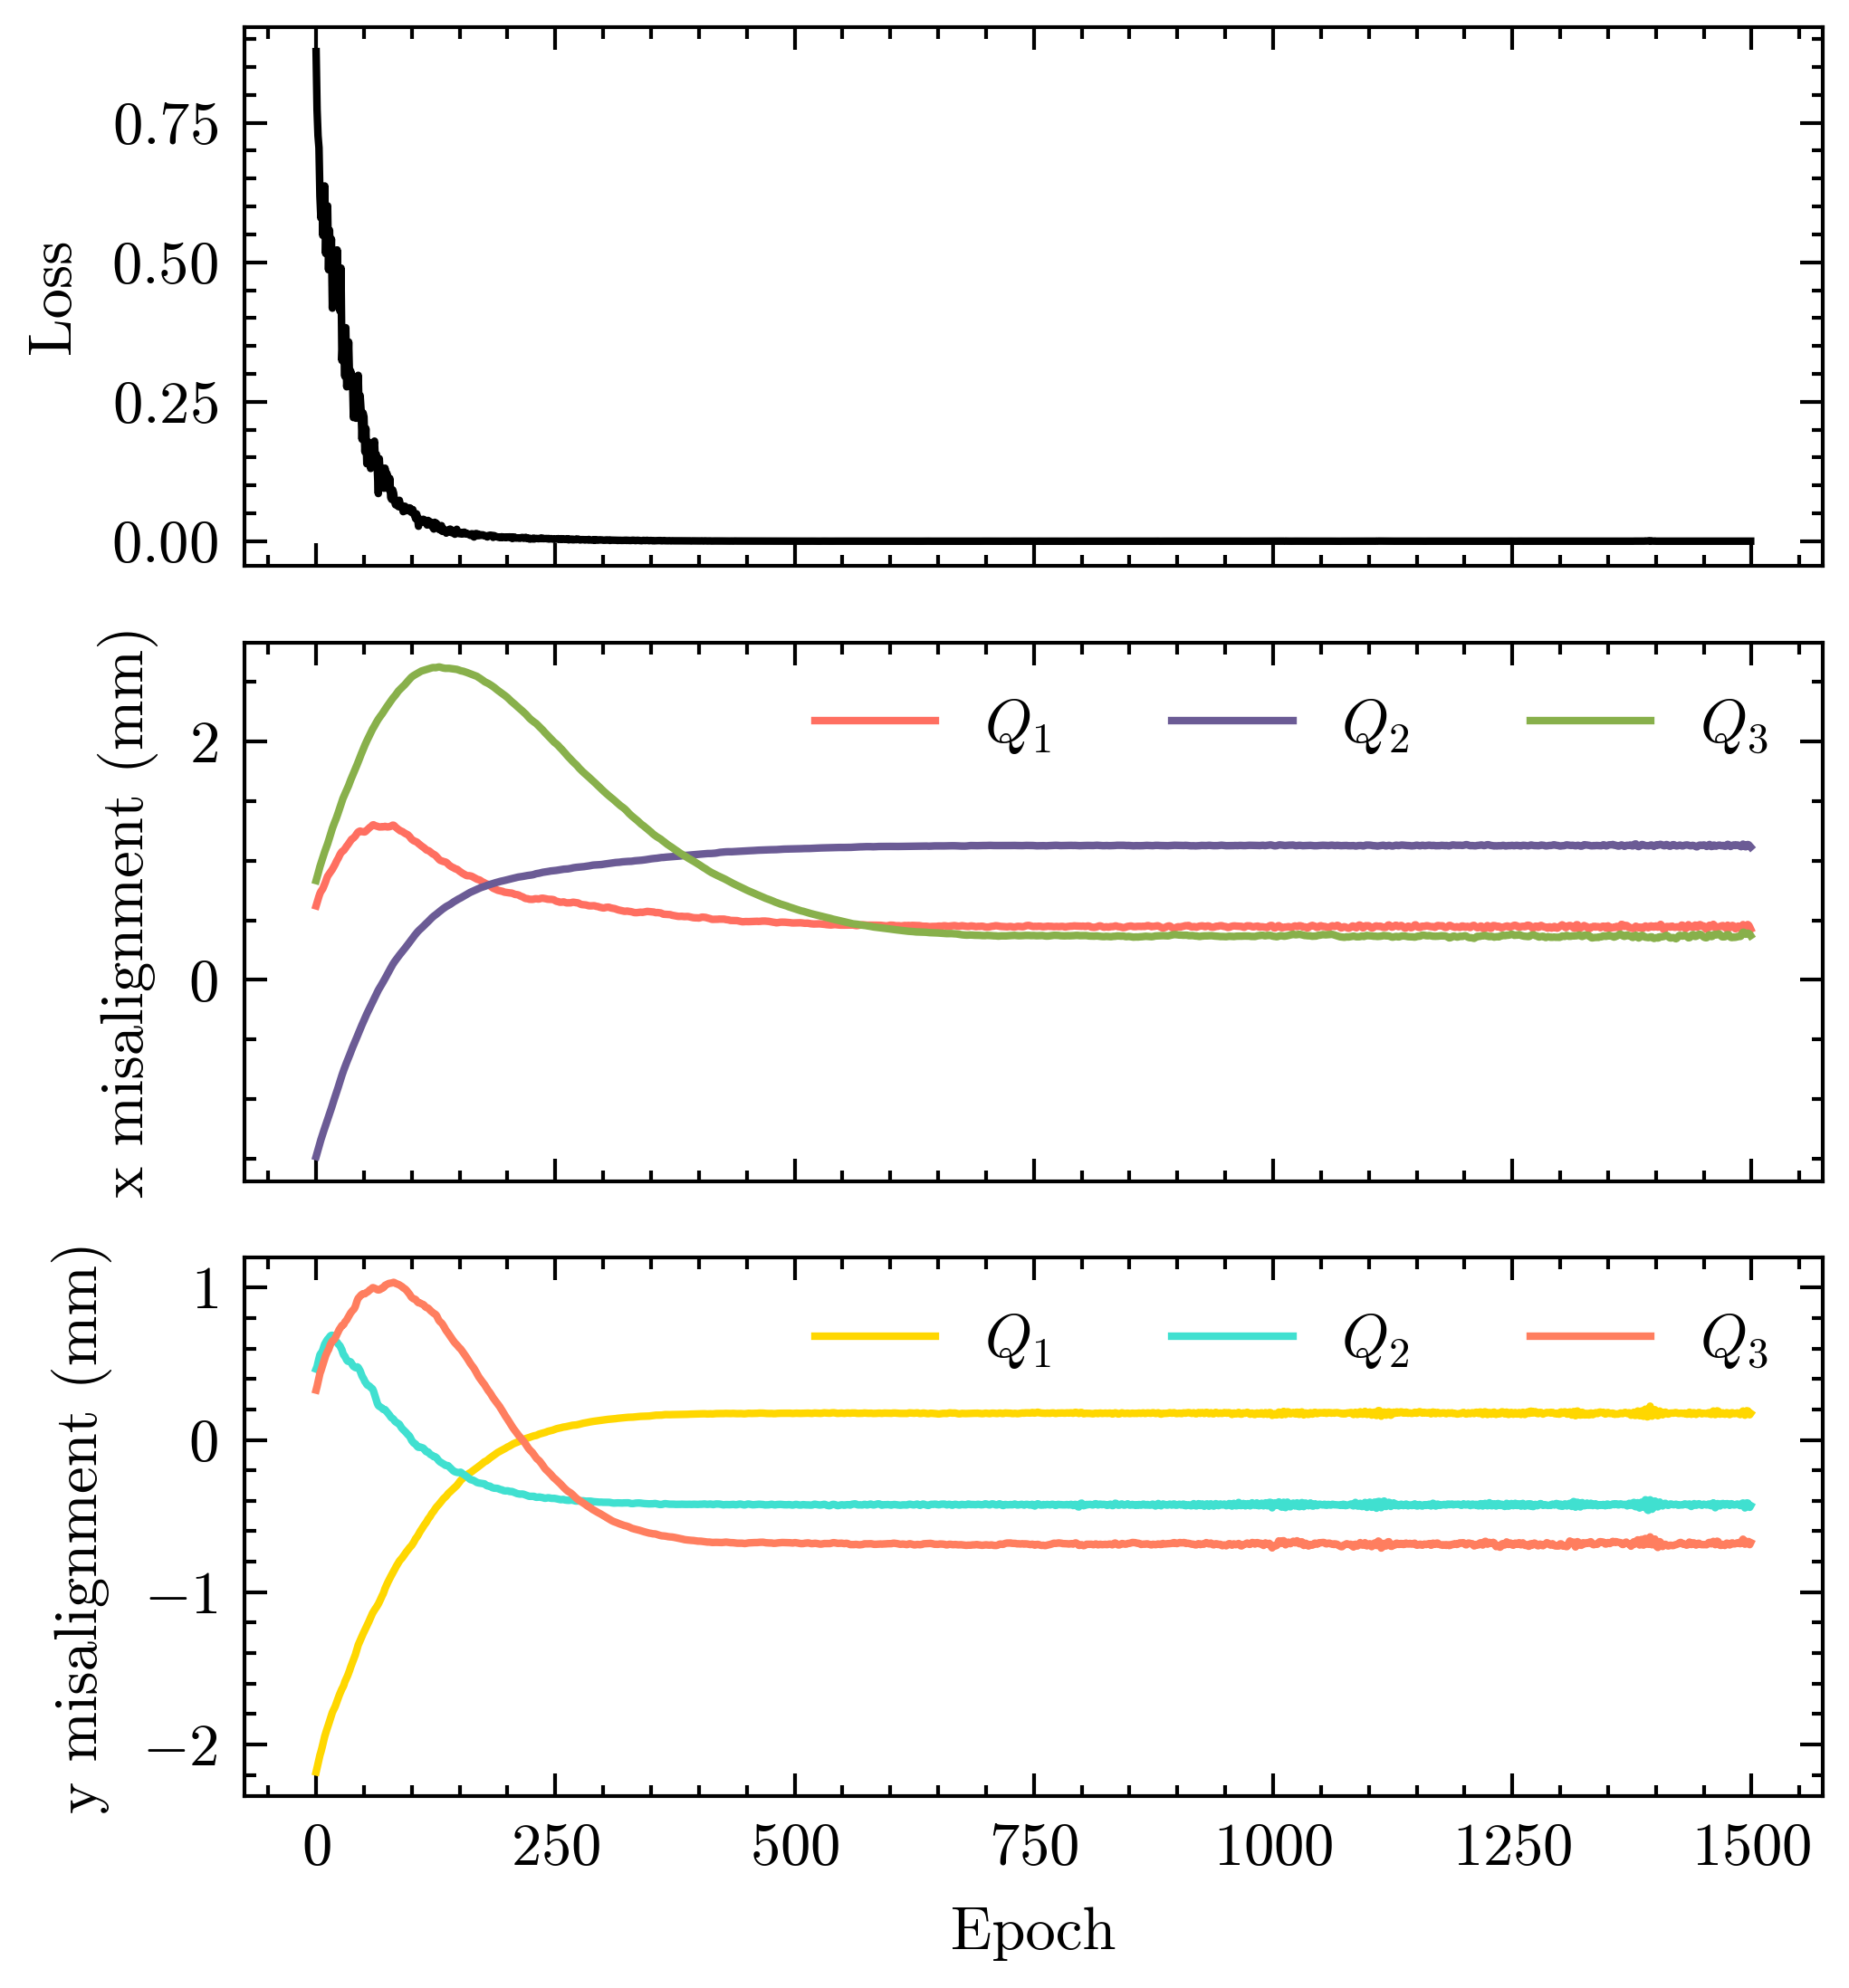

In [15]:
plot_training(history_3)

In [16]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_rl_sim_data")
history_4 = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)

100%|██████████| 1500/1500 [02:36<00:00,  9.59it/s]


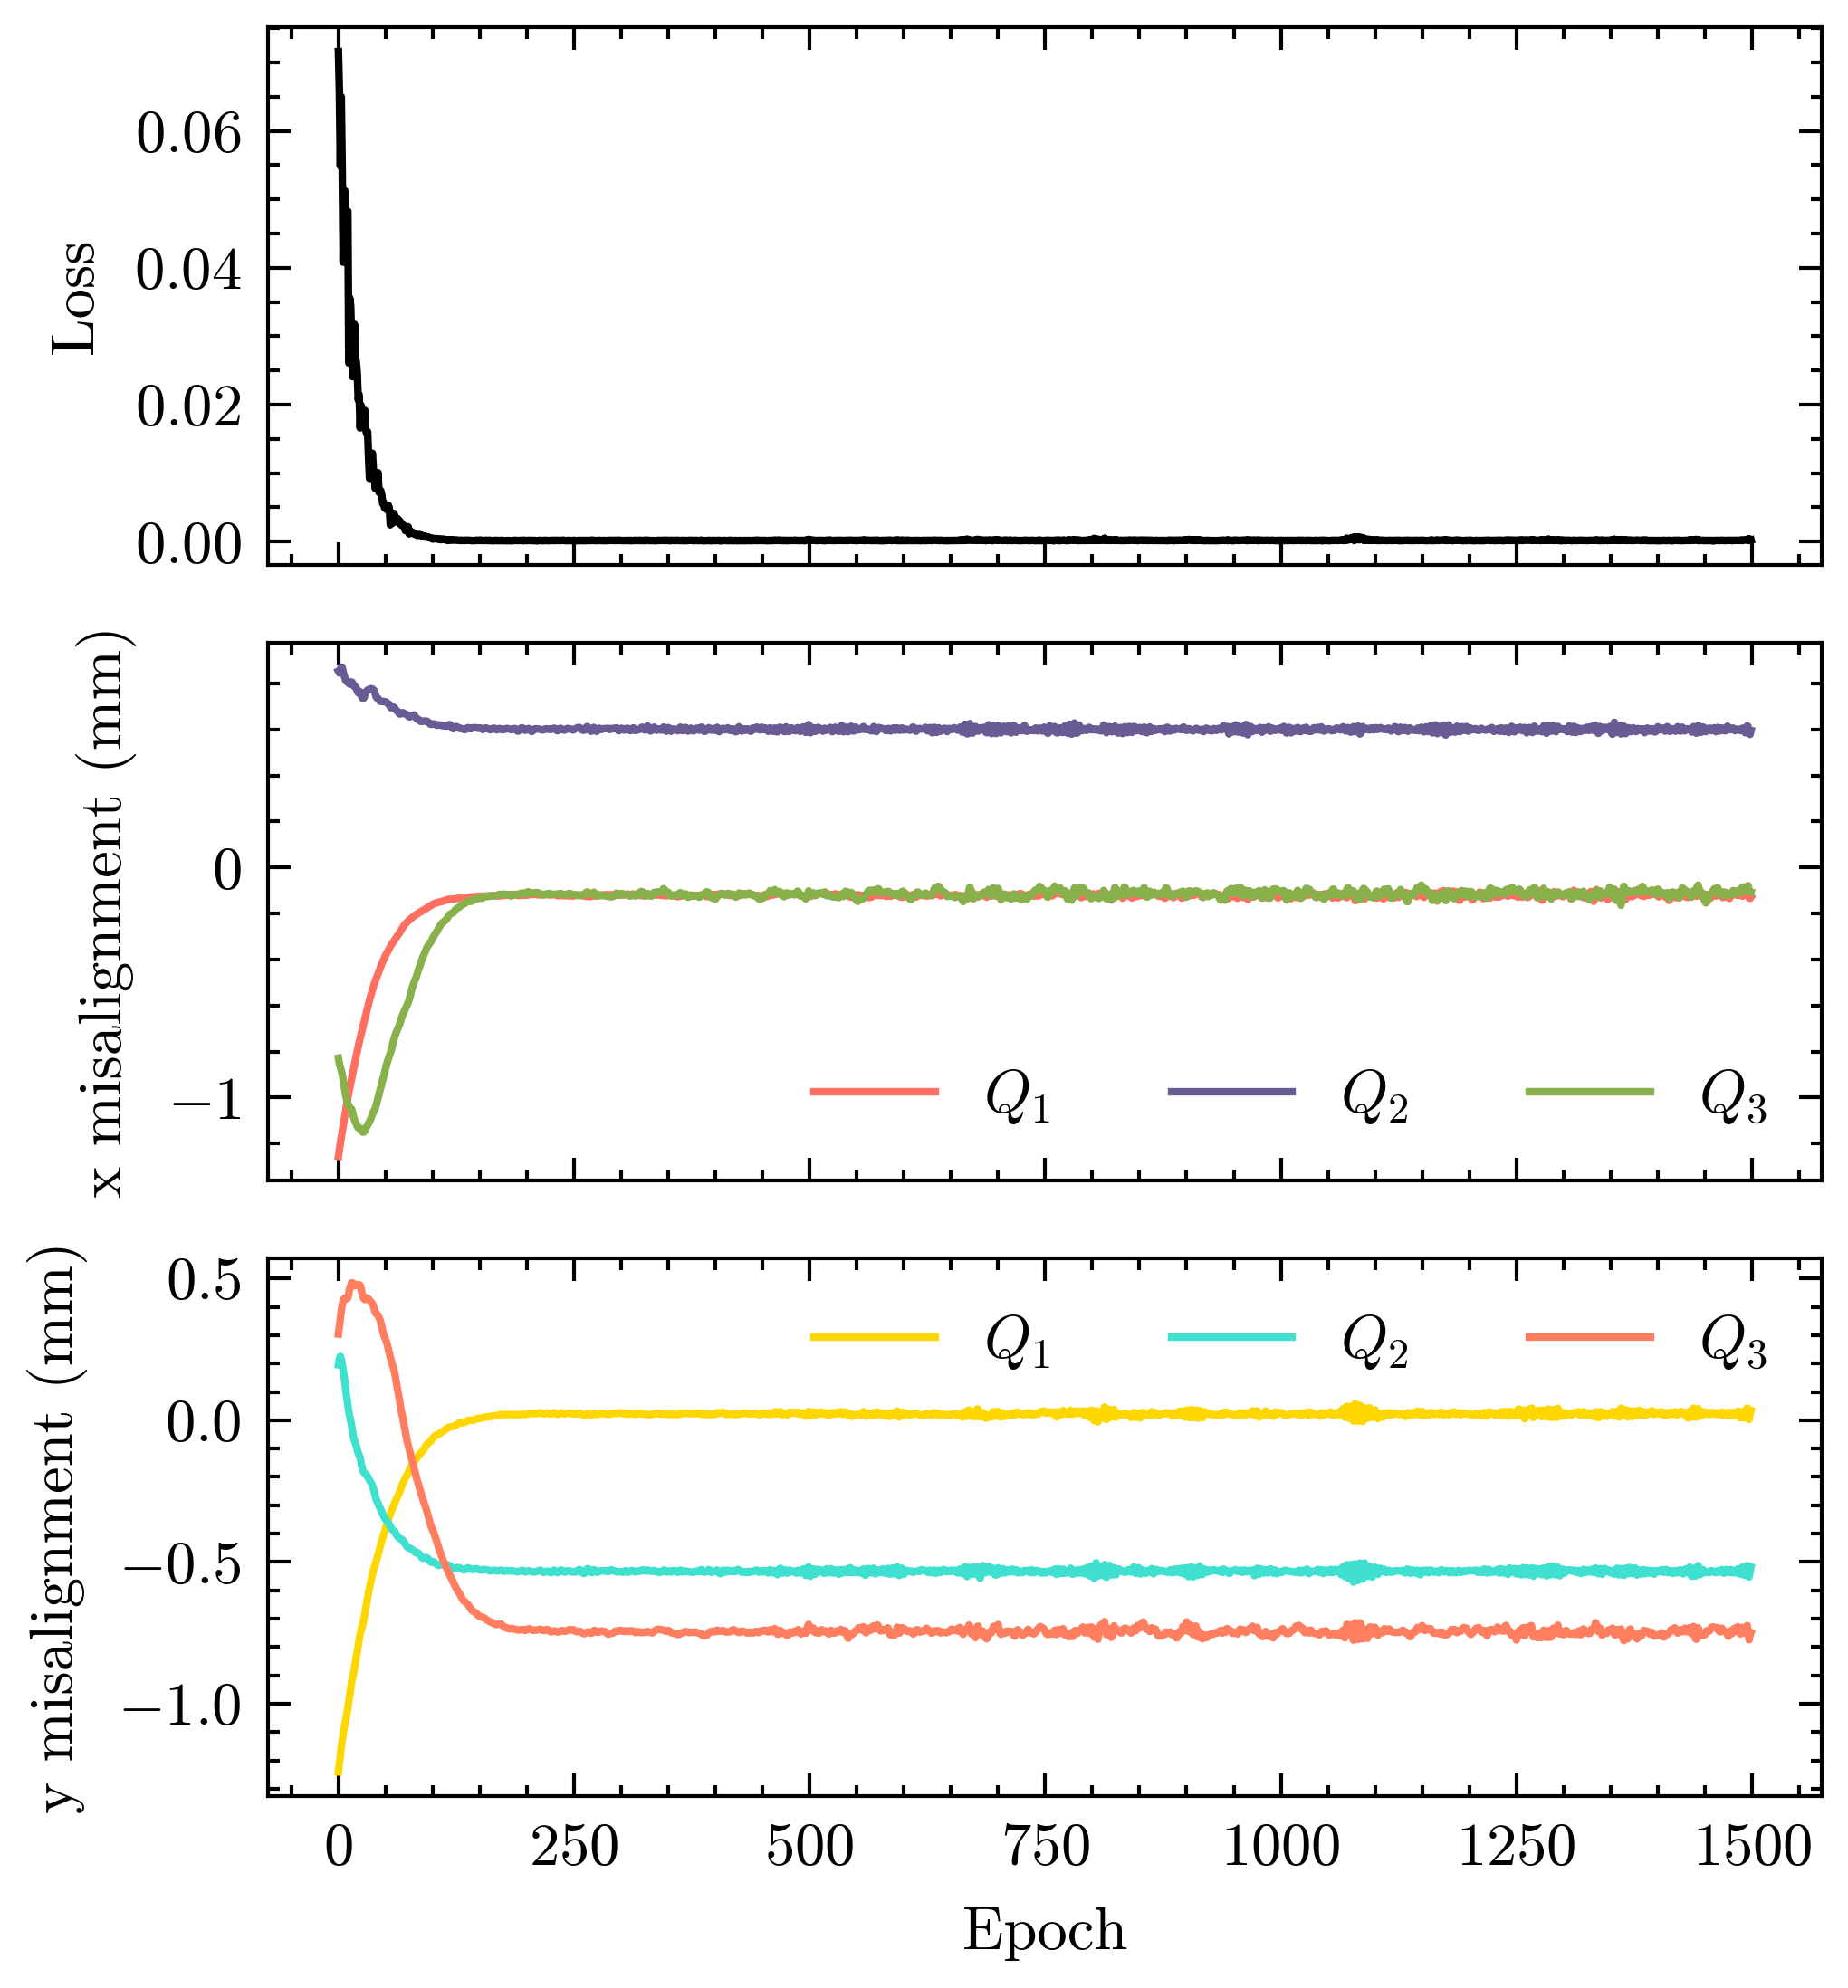

In [17]:
plot_training(history_4)

In [18]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history_5 = train_normalized(model=normalized_ares_ea, num_epochs=1_000, data=bo_data)

100%|██████████| 1000/1000 [02:41<00:00,  6.19it/s]


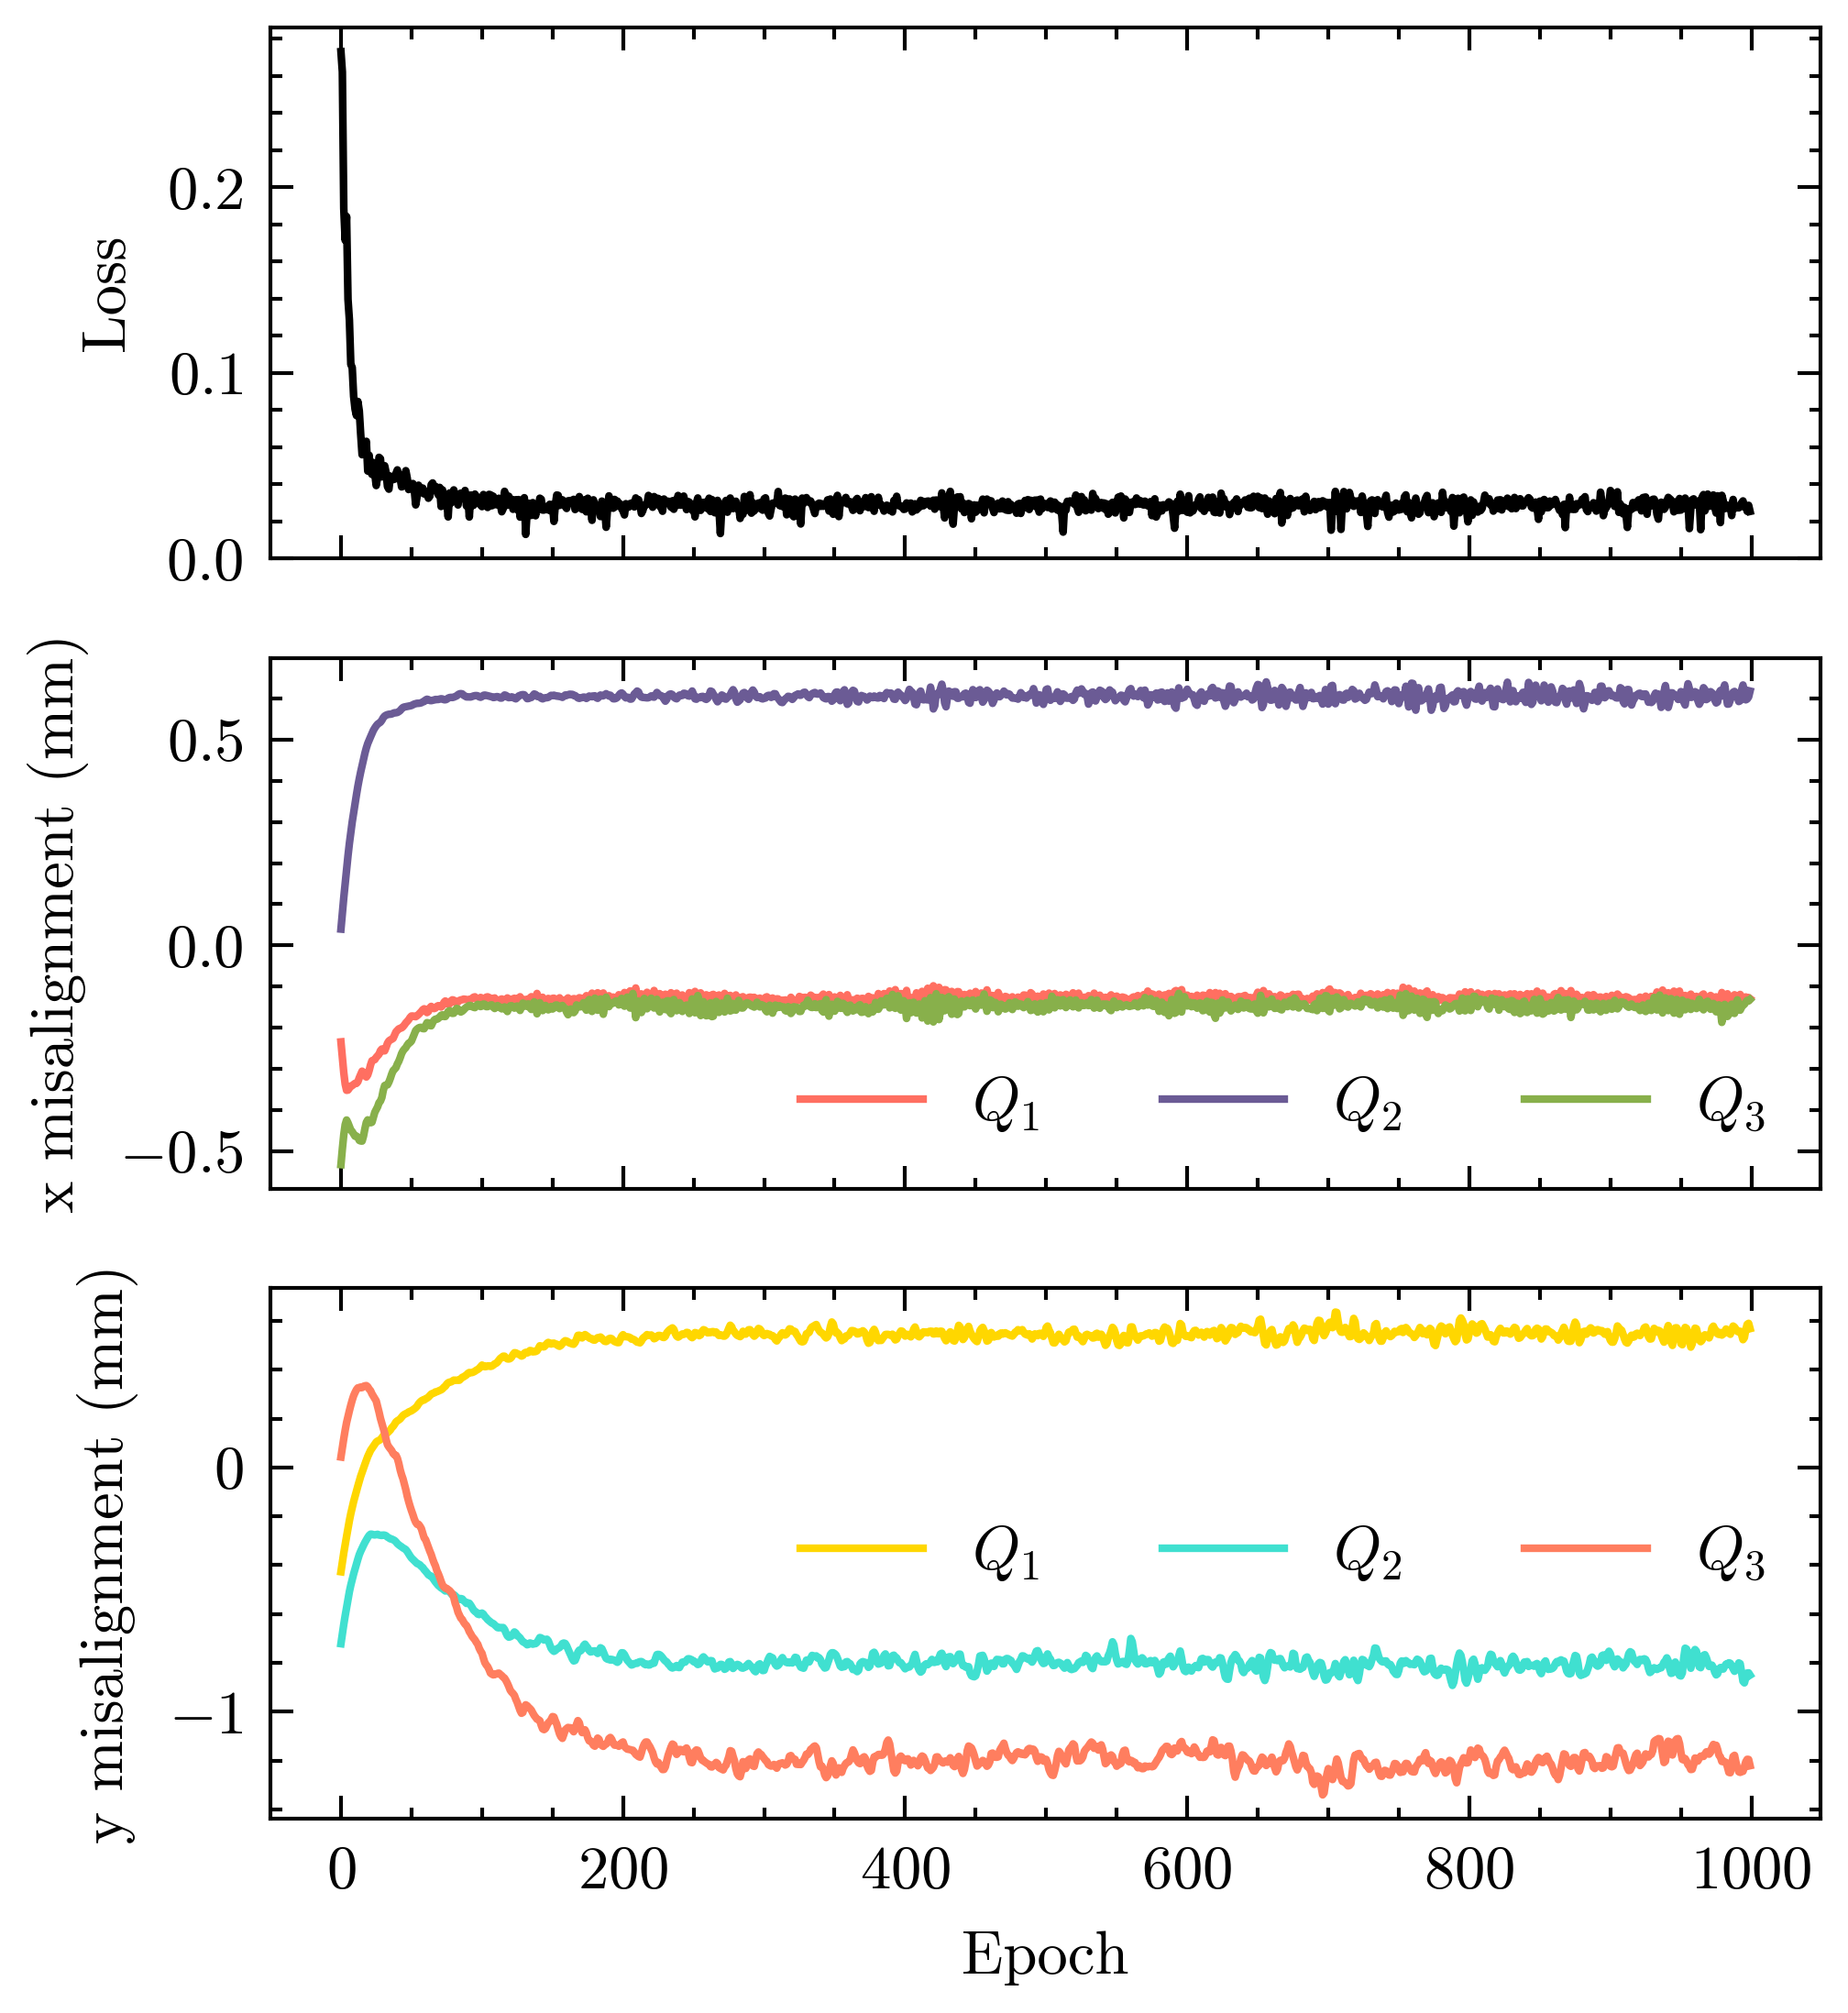

In [19]:
plot_training(history_5)

In [20]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history_6 = train_normalized(
    model=normalized_ares_ea, num_epochs=600, data=real_combined
)

100%|██████████| 600/600 [02:45<00:00,  3.64it/s]


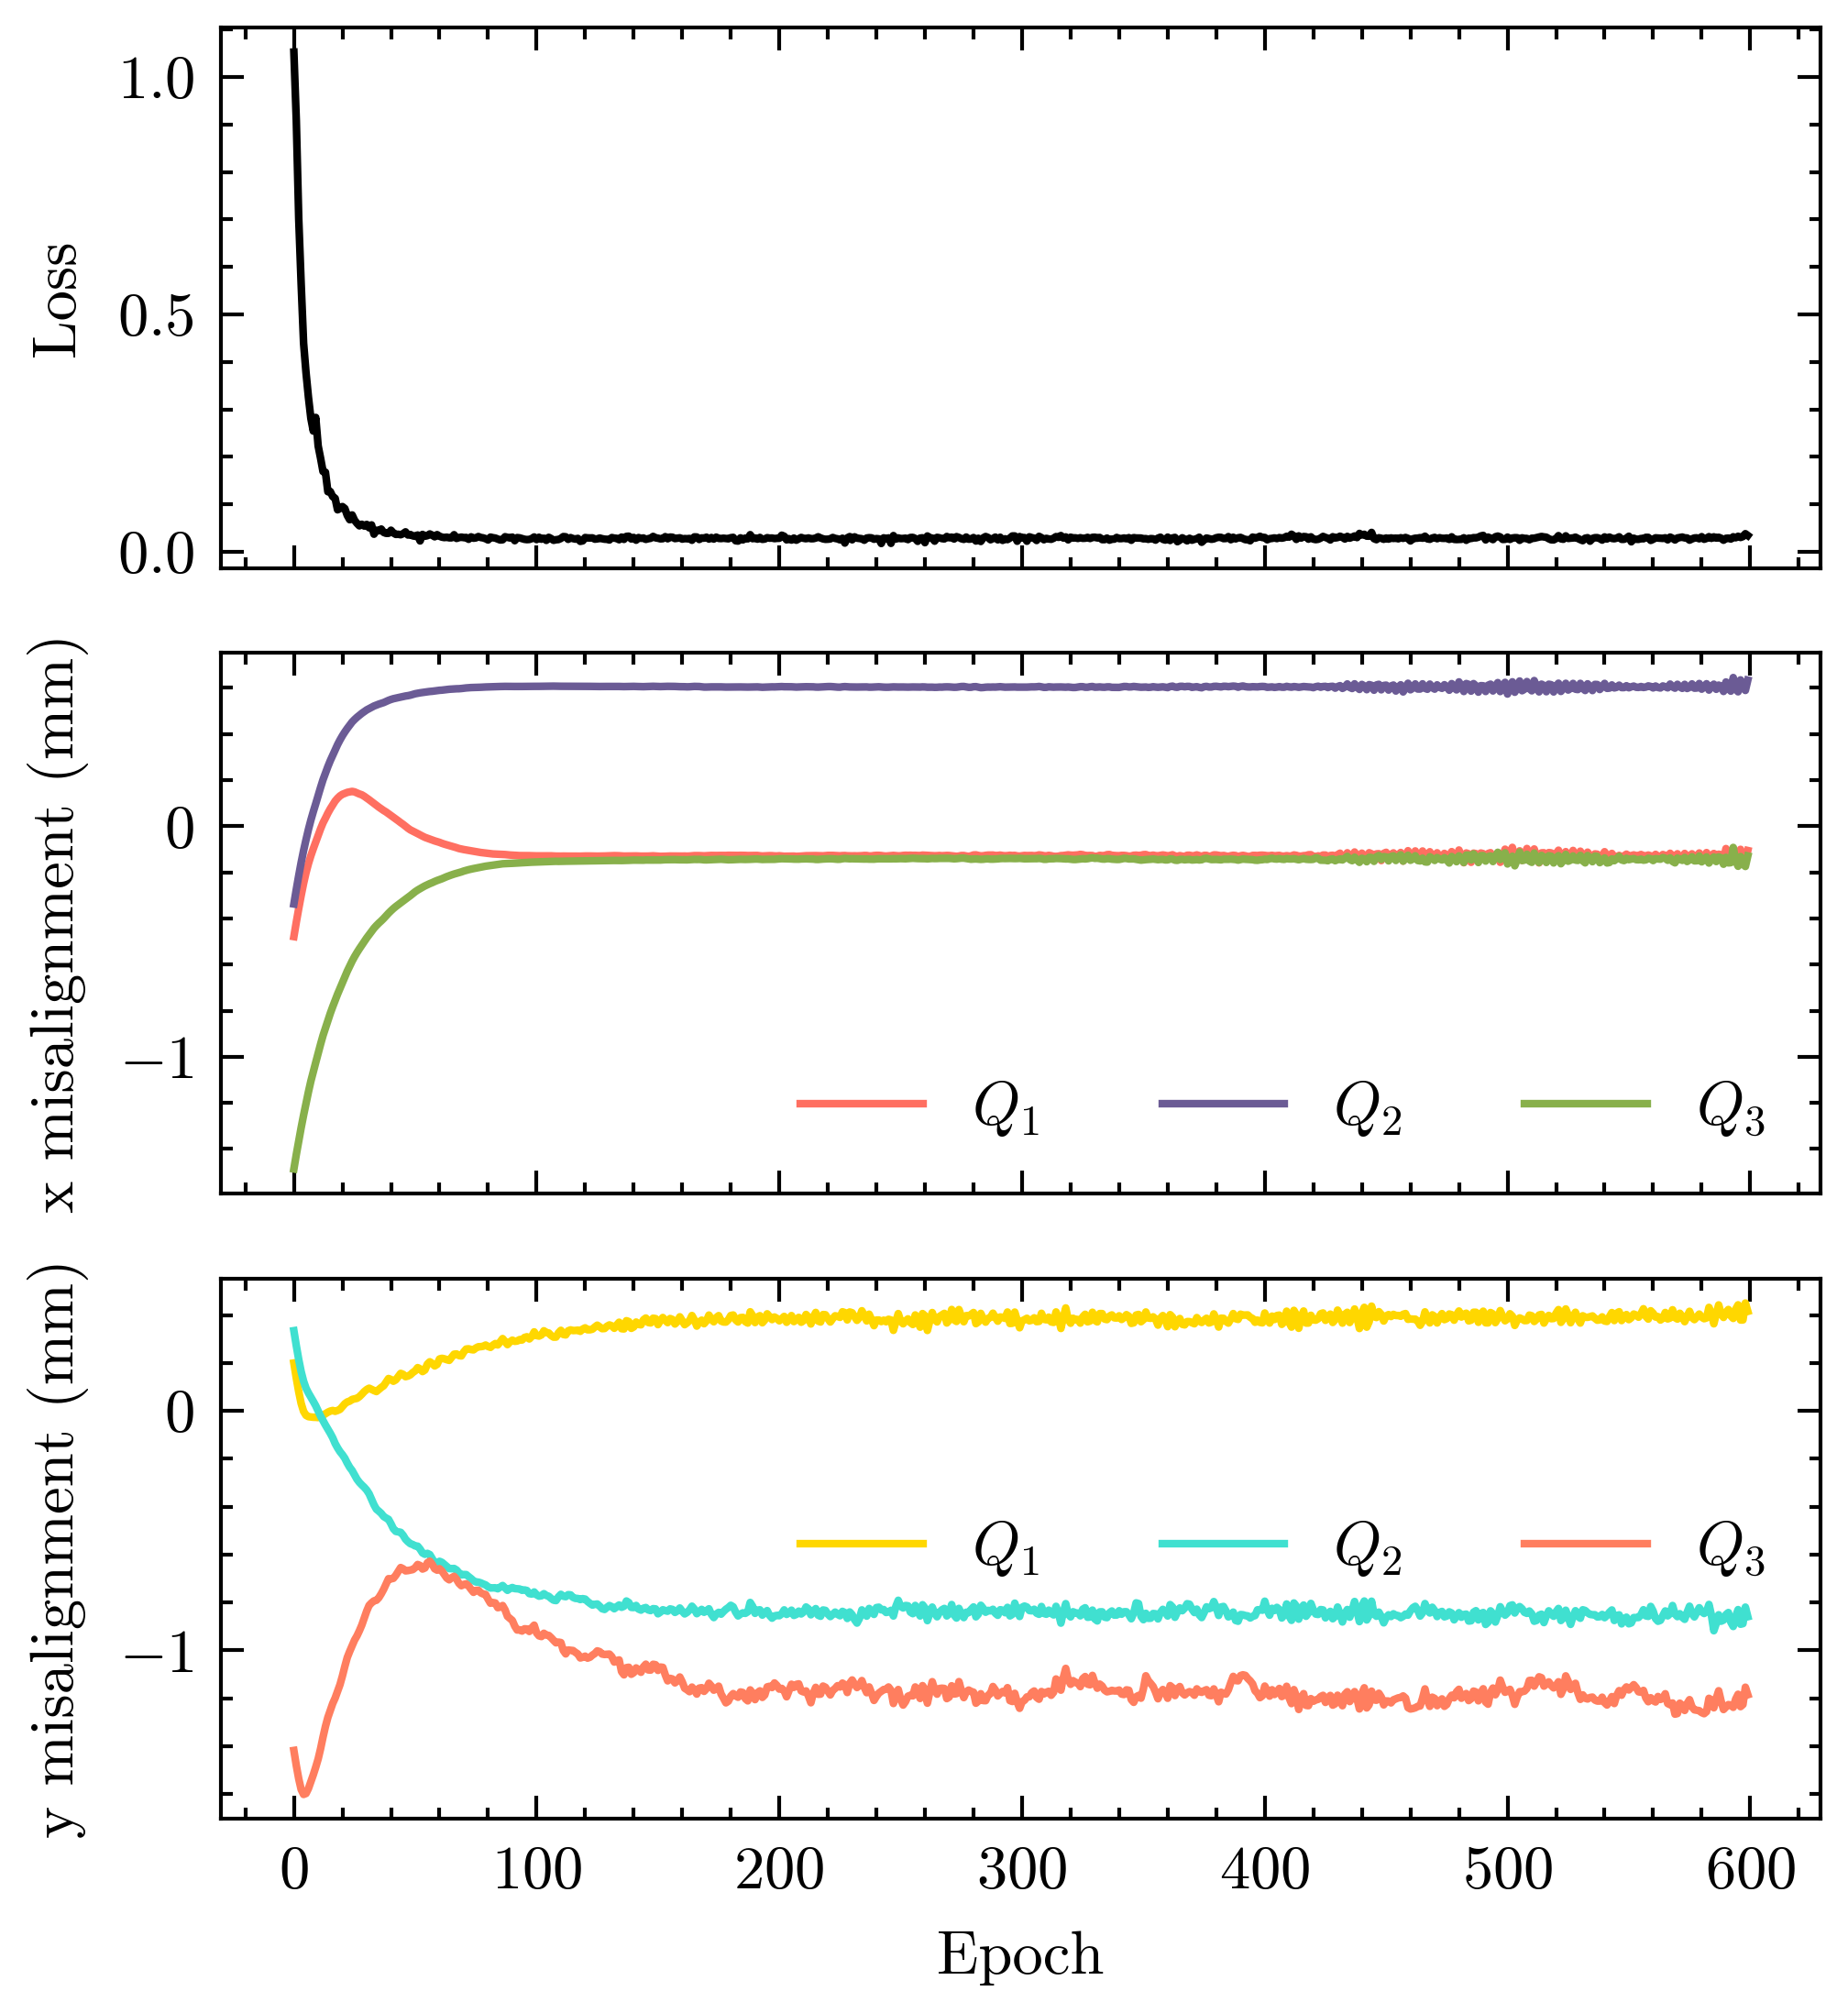

In [21]:
plot_training(history_6)

In [22]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="rl_sim_data")
history_7 = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [02:31<00:00,  3.29it/s]


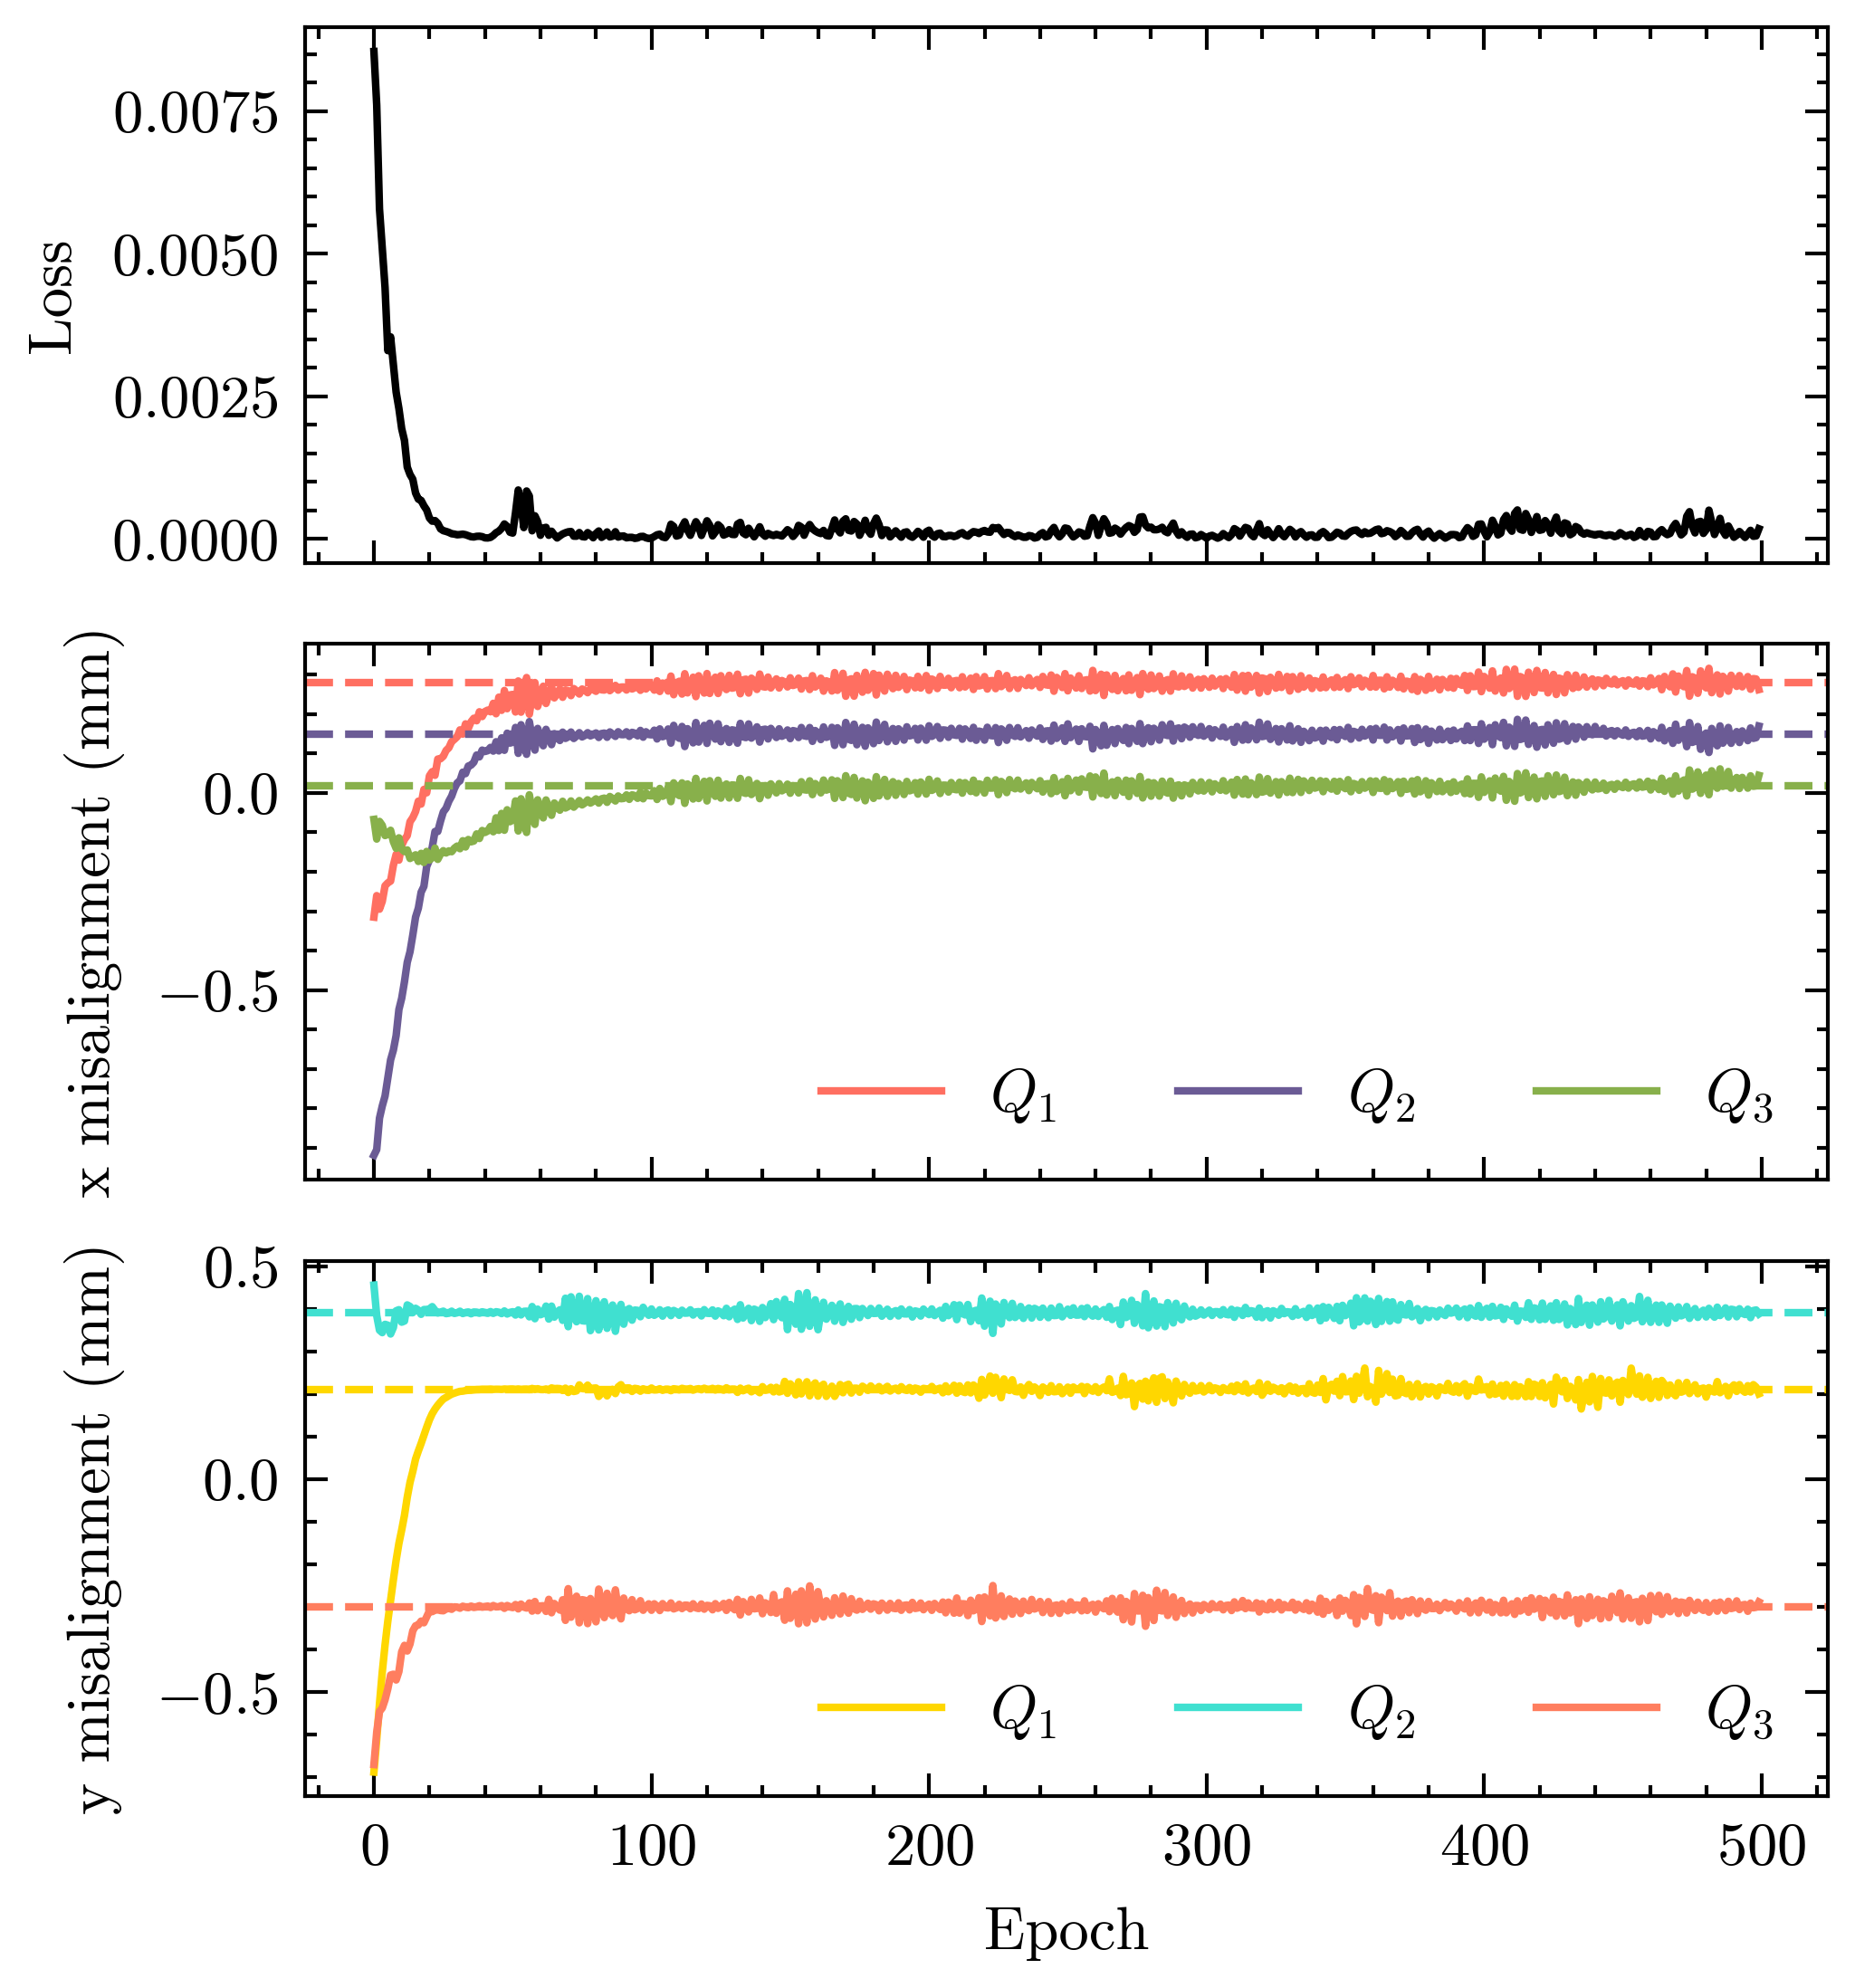

In [23]:
plot_training(
    history_7,
    ground_truth=rl_data_sim["observations"][0]["misalignments"],
    save_path="system_id_simulation_known.pdf",
)

In [24]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history_8 = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)

100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


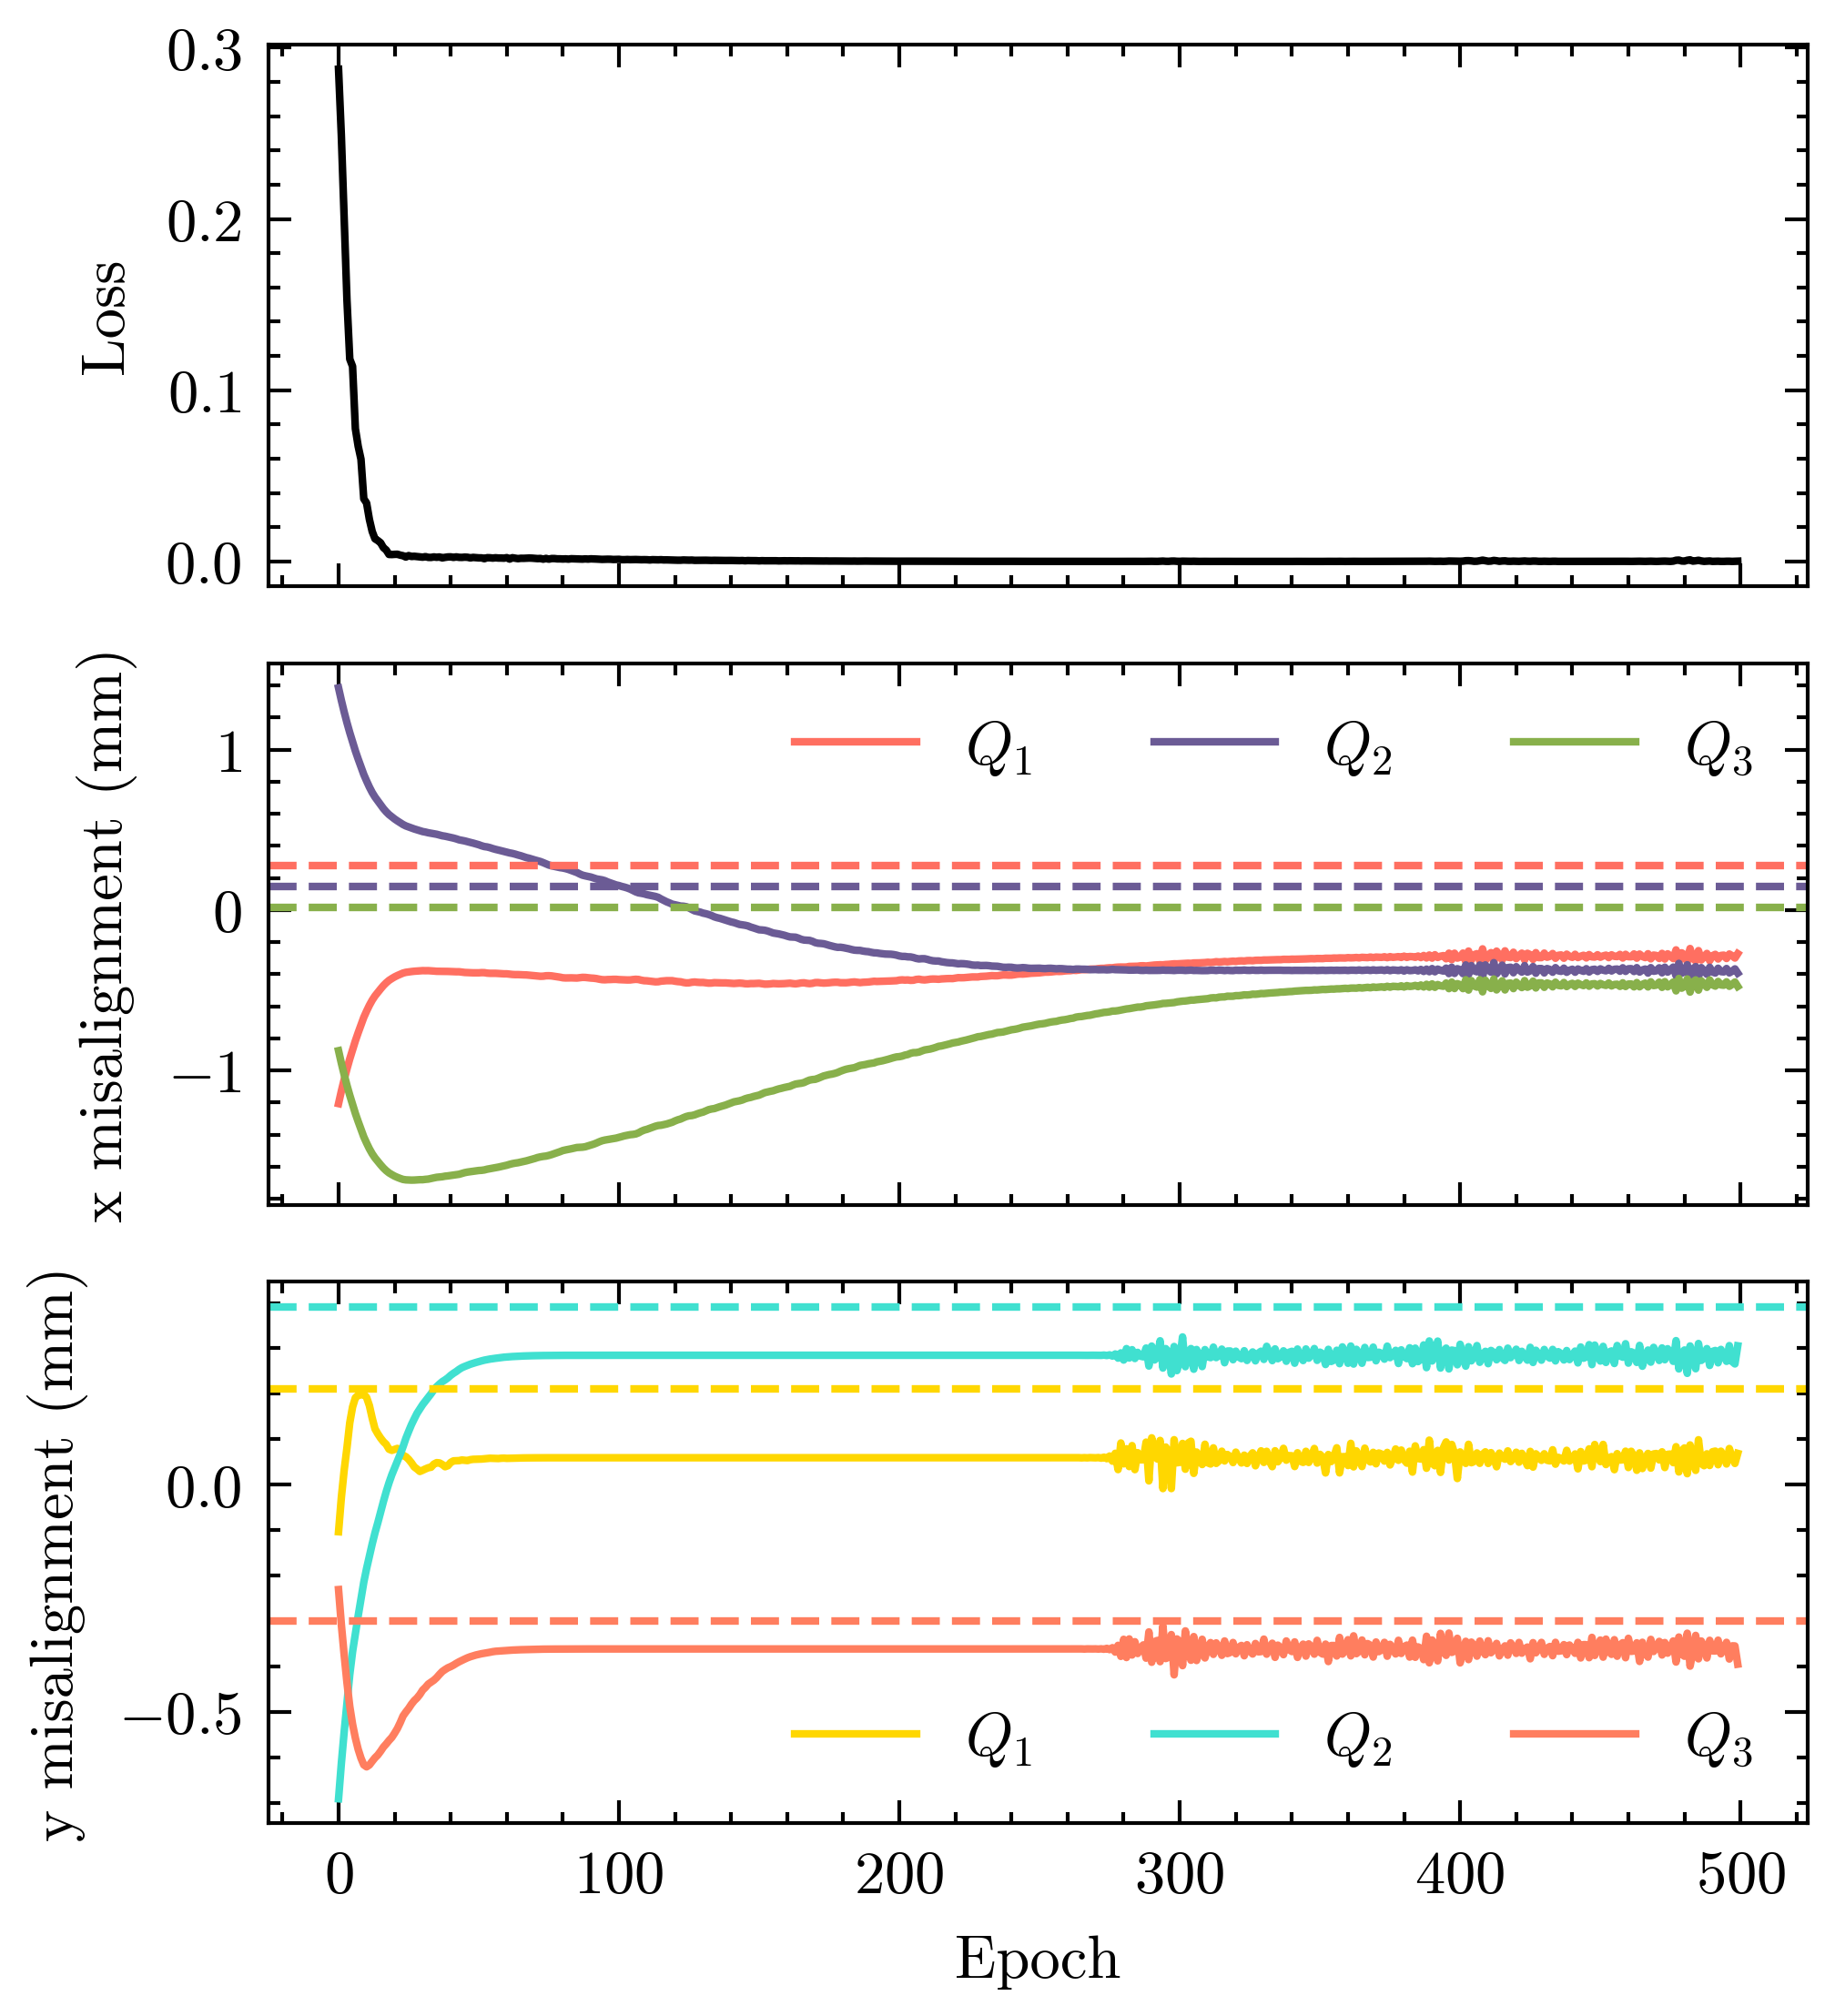

In [25]:
plot_training(
    history_8,
    ground_truth=rl_data_sim["observations"][0]["misalignments"],
    save_path="system_id_simulation_unknown.pdf",
)

In [26]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_rl_sim_data")
history_9 = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)

100%|██████████| 500/500 [02:37<00:00,  3.18it/s]


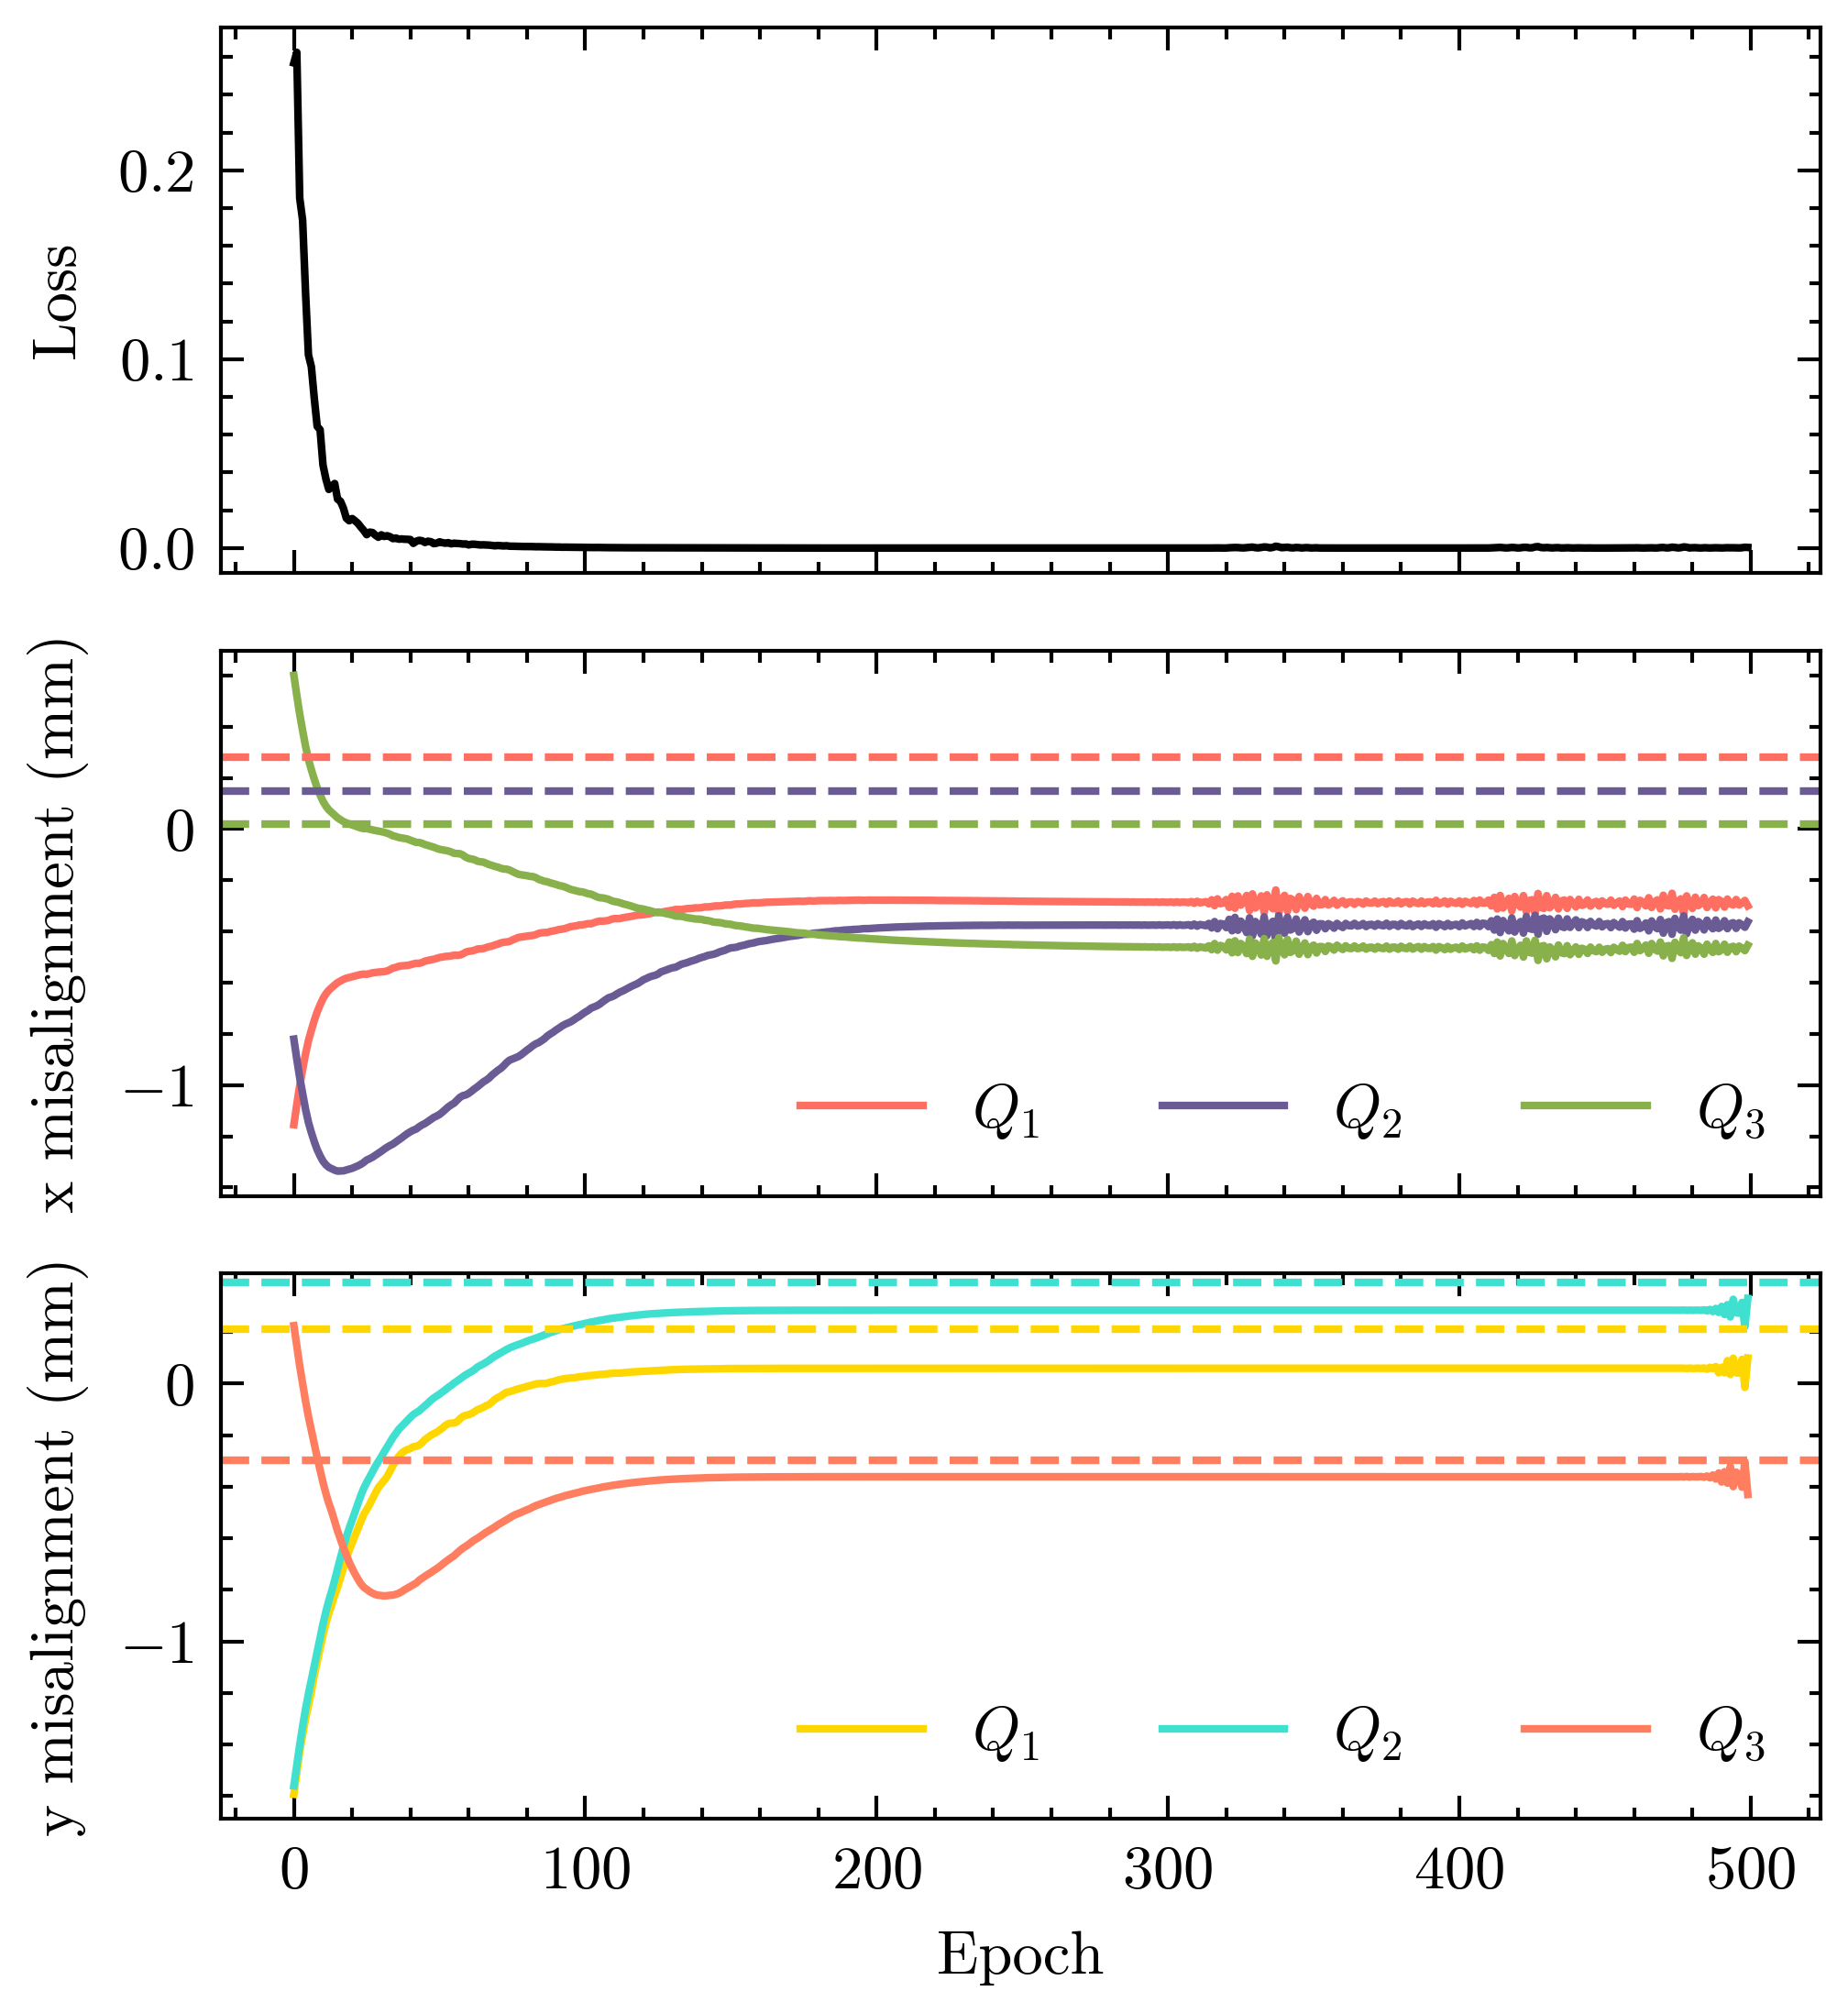

In [27]:
plot_training(history_9, ground_truth=rl_data_sim["observations"][0]["misalignments"])

In [28]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="uncentered_astra")
history_10 = train_normalized(
    model=normalized_ares_ea, num_epochs=500, data=rl_data_sim
)

100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


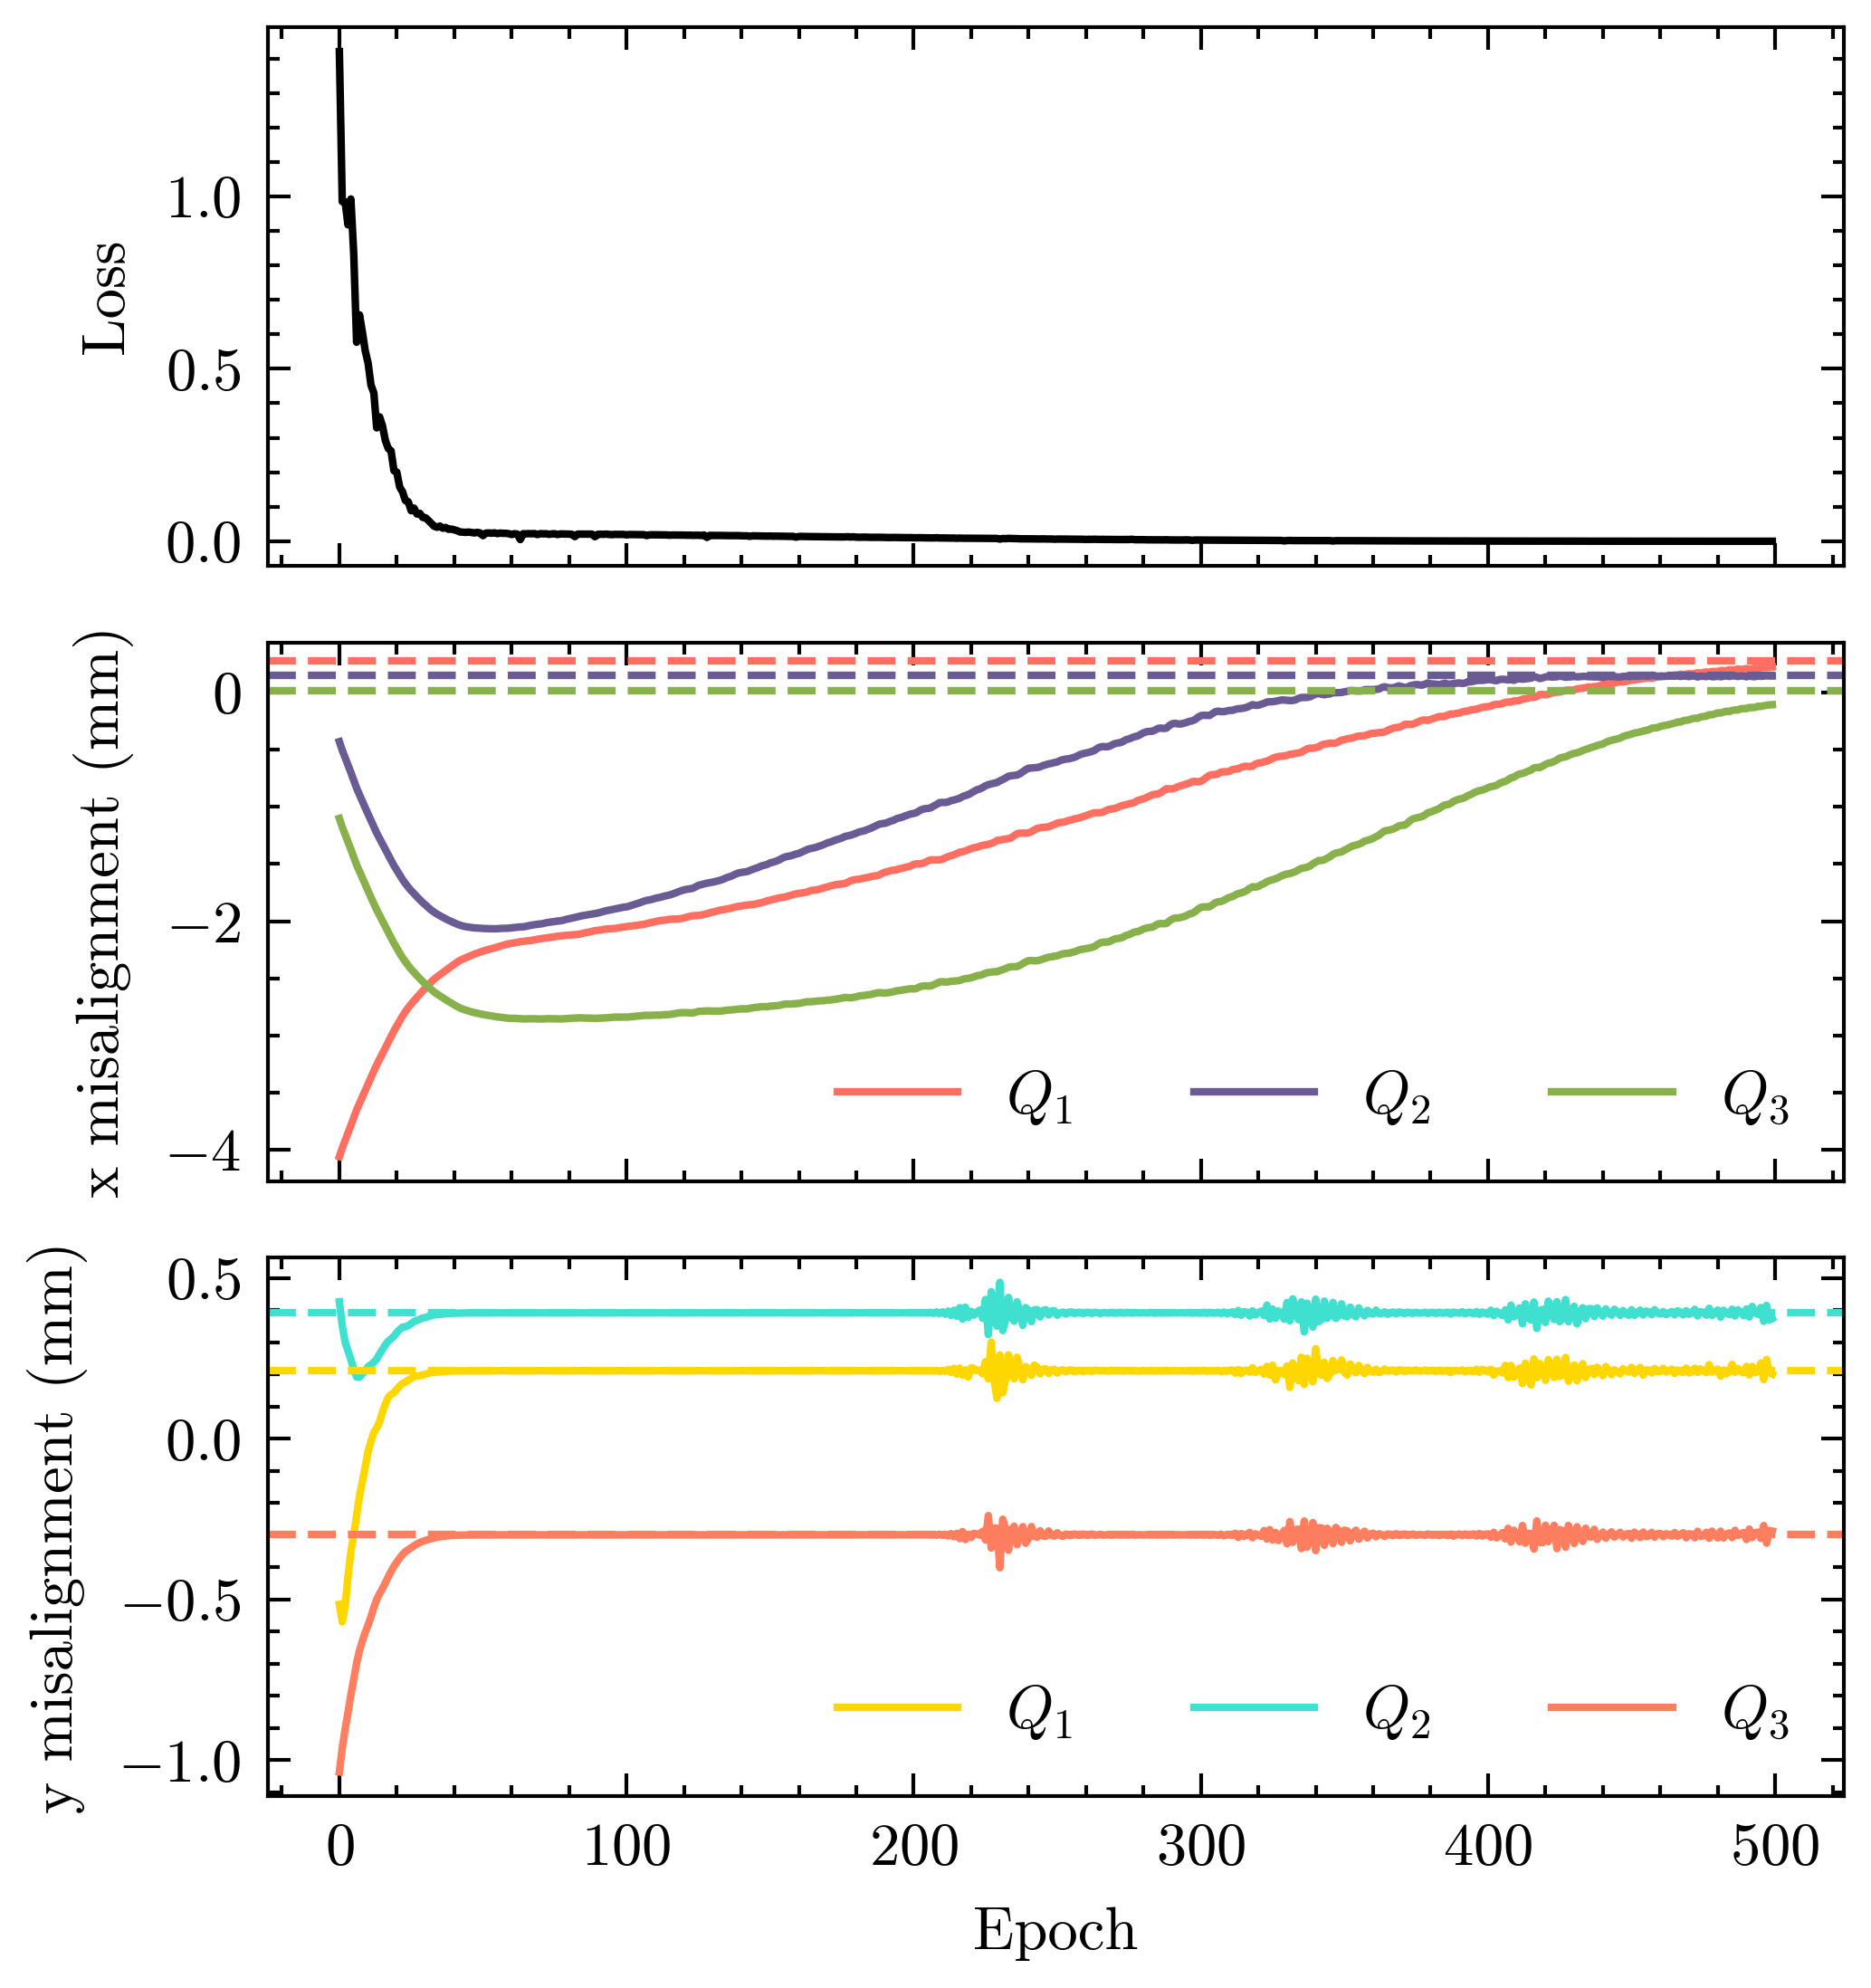

In [29]:
plot_training(history_10, ground_truth=rl_data_sim["observations"][0]["misalignments"])